# Neural Manifold Analysis Pipeline

## Table of Contents
- [Parameters to Set](#parameters-to-set)
- [Load Data](#load-data)
- [Process Tensor Data](#process-tensor-data-smoothing-and-selecting-frequencies)
- [Save Tensor for Tensor Decomposition](#save-tensor-for-tensor-decomposition)
- [Load Decomposition Result](#load-decomposition-result)
- [Plot Total Normalized Explained Variance](#plot-total-normalized-explained-variance)
- [Choose Number of Factors R](#choose-number-of-factors-r)
- [Replot with Factors R](#replot-highlighting-for-factors-r)
- [Visualize Factors](#visualize-factors)
- [Data Processing](#data-processing)
- [Outlier Analysis](#outlier-analysis---visualizing-distance-distributions-and-potential-outliers)
- [Run IAN](#run-ian)
- [Graph Analysis](#graph-analysis)
- [Plot 2D Manifold](#plot-2d-manifold)
- [Compute MDS Embedding](#compute-mds-embedding-for-better-visualization)
- [Run HDBSCAN Clustering](#run-hdbscan-clustering-to-estimate-number-of-clusters)
- [Plot 3D Manifold](#plot-3d-manifold)
- [Generate Neuron Response Plots](#generate-plots-showing-neuron-responses-for-different-stimuli)
- [Advanced Analysis](#advanced-analysis)
- [2D Manifold by Clusters](#2d-manifold-colored-by-clusters)
- [OSI and Preferred Stimulus](#osi-and-preferred-stimulus-colored-3d-manifold)
- [Factor Visualization on Manifolds](#factor-visualization-on-manifolds)
- [Neighborhood Analysis](#neighborhood-analysis)
- [Local Dimensionality](#local-dimensionality)

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
import logging
import os
import json
from scipy.io import savemat
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import pdist, squareform
from scipy import sparse
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, leaves_list, optimal_leaf_ordering, dendrogram
from sklearn.decomposition import PCA, KernelPCA
from umap import umap_
from hdbscan.hdbscan_ import _tree_to_labels
from hdbscan.plots import CondensedTree
import plotly.graph_objects as go
from matplotlib.backends.backend_pdf import PdfPages

from tueplots import bundles
from tueplots.constants.color import rgb
from utils import *

from ian.ian import * #https://github.com/dyballa/IAN/
from ian.embed_utils import *
from ian.dset_utils import *
from ian.utils import *

logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
plt.rcParams.update(bundles.neurips2021(usetex=False))

results_dict = {}

## Parameters to set

In [153]:
# Layer 1
#PREFIX = 'original_res50_shifted_act_i3_n2000_SCL0_5_TL37_layer1_maxFr_maxNr'
#PREFIX = 'res50_shifted_act_i3_n2000_SCL0_5_TL37_layer1_maxFr_maxNr' 
#PREFIX = 'recurrent_res50_shifted_act_i3_n2000_SCL0_5_TL37_layer1_maxFr_maxNr'
#PREFIX = 'res50_shifted_act_i3_n1000_SCL0_5_TL37_layer1_maxFr_maxNr'
#PREFIX = 'gaussiannoiseres50_shifted_act_i3_n1000_SCL0_5_TL37_layer1_maxFr_maxNr'
#PREFIX = 'res50_shifted_act_i3_n1000_SCL0_5_TL37_layer1_maxFr_maxNr_seed1'#savik
#PREFIX = 'res50_shifted_act_i3_n1000_SCL0_5_TL37_layer1_maxFr_maxNr_seed2'
#PREFIX = 'res50_shifted_act_i3_n1000_SCL0_5_TL37_layer1_maxFr_maxNr_seed3'
#PREFIX = 'nwm_res50_act_i3_n2000_SCL0_5_TL37_layer1_maxFr_maxNr_seed1'

# Layer 3
#PREFIX = 'recurrent_res50_shifted_act_i3_n2000_SCL0_5_TL37_layer3_maxFr_maxNr'    
#PREFIX = 'res50_shifted_act_i3_n1000_SCL0_5_TL37_layer3_maxFr_maxNr'


# Layer 4
#PREFIX = 'res50_shifted_act_i3_n250_SCL0_5_TL37_layer4_maxFr_maxNr'  # 10 * 25
#PREFIX = 'res50_shifted_act_i3_n400_SCL0_5_TL37_layer4_maxFr_maxNr'  # 40 * 10
#PREFIX = 'res50_shifted_act_i3_n500_SCL0_5_TL37_layer4_maxFr_maxNr'  # 20 * 25
#PREFIX = 'res50_shifted_act_i3_n650_SCL0_5_TL37_layer4_maxFr_maxNr' # 26 * 25
#PREFIX = 'res50_shifted_act_i3_n800_SCL0_5_TL37_layer4_maxFr_maxNr'  # 80 * 10
#PREFIX = 'res50_shifted_act_i3_n1000_SCL0_5_TL37_layer4_maxFr_maxNr'  # 40 * 25
#PREFIX = 'res50_shifted_act_i3_n1000_SCL0_5_TL37_layer4_maxFr_maxNr_seed1' # 40 * 25#savik
#PREFIX = 'gaussiannoiseres50_shifted_act_i3_n1000_SCL0_5_TL37_layer4_maxFr_maxNr_seed1' # 40 * 25
#PREFIX = 'gaussian1noiseres50_shifted_act_i3_n1000_SCL0_5_TL37_layer4_maxFr_maxNr_seed1'
#PREFIX = 'res50_shifted_act_i3_n1000_SCL0_5_TL37_layer4_maxFr_maxNr_seed2' # 40 * 25
#PREFIX = 'res50_shifted_act_i3_n1000_SCL0_5_TL37_layer4_maxFr_maxNr_seed3' # 40 * 25
#PREFIX = 'res50_shifted_act_i3_n2000_SCL0_5_TL37_layer4_maxFr_maxNr'  # 80 * 25
#PREFIX = 'res50_shifted_act_i3_n2000_SCL0_5_TL37_layer4_maxFr_maxNr_seed1' # 80*25
#PREFIX = 'res50_shifted_act_i3_n6000_SCL0_5_TL37_layer4_maxFr_maxNr' # 240 * 25
#PREFIX = 'res50_shifted_act_i3_n10000_SCL0_5_TL37_layer4_maxFr_maxNr'  # 1000 * 10
#PREFIX = 'res50_shifted_act_i3_n9800_SCL0_5_TL37_layer4_maxFr_maxNr' # 490 * 20

#PREFIX = 'recurrent_res50_shifted_act_i3_n250_SCL0_5_TL37_layer4_maxFr_maxNr'  # 10 * 25
#PREFIX = 'recurrent_res50_shifted_act_i3_n400_SCL0_5_TL37_layer4_maxFr_maxNr'  # 40 * 10
#PREFIX = 'recurrent_res50_shifted_act_i3_n500_SCL0_5_TL37_layer4_maxFr_maxNr'  # 20 * 25
#PREFIX = 'recurrent_res50_shifted_act_i3_n800_SCL0_5_TL37_layer4_maxFr_maxNr'  # 80 * 10
####PREFIX = 'recurrent_res50_shifted_act_i3_n995_SCL0_5_TL37_layer4_maxFr_maxNr'  # 40 * 25
#PREFIX = 'recurrent_res50_shifted_act_i3_n1995_SCL0_5_TL37_layer4_maxFr_maxNr'  # 80 * 25

#PREFIX = 'noisy_res50_shifted_act_i3_n989_SCL0_5_TL37_layer4_maxFr_maxNr'

#PREFIX = "nonlocal_res50_act_i3_n1000_SCL0_5_TL37_layer4_maxFr_maxNr_seed1"

#PREFIX = 'nwm_res50_act_i3_n1000_SCL0_5_TL37_layer4_maxFr_maxNr_seed1'

# Last Layer only
#PREFIX = 'last_res50_shifted_act_i3_n1000_SCL0_5_TL37_layer4_maxFr_maxNr'

#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_inputs0_maxFr_maxNr_seed1"
#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_blocks0_maxFr_maxNr_seed1"
#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_inputs1_maxFr_maxNr_seed1"
#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_blocks1_maxFr_maxNr_seed1"
#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_inputs2_maxFr_maxNr_seed1"
#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_blocks2_maxFr_maxNr_seed1"
#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_hidden_maxFr_maxNr_seed1"
#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_recurrentout_maxFr_maxNr_seed1"
#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_position_maxFr_maxNr_seed1"
PREFIX = "fnn07_seed2" #1000
#PREFIX = "fnn07_seed3" #2000

#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_inputs0_maxFr_maxNr_seed3"
#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_inputs1_maxFr_maxNr_seed3"
#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_inputs2_maxFr_maxNr_seed3"
#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_blocks0_maxFr_maxNr_seed3"
#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_blocks1_maxFr_maxNr_seed3"
#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_blocks2_maxFr_maxNr_seed2"
#PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_hidden_maxFr_maxNr_seed3"

#PREFIX = "fnn"#savik
#PREFIX = "gaussiannoisefnn"
#PREFIX = "fnn_seed2"

#PREFIX = "fnn_act_i3_n2000_SCL0_5_TL37_blocks0_maxFr_maxNr_seed2"#savik
#PREFIX = "fnn_act_i3_n2000_SCL0_5_TL37_blocks1_maxFr_maxNr_seed1"
#PREFIX = "fnn_act_i3_n2000_SCL0_5_TL37_blocks1_maxFr_maxNr_seed2"#savik
#PREFIX = "fnn_act_i3_n750_SCL0_5_TL37_blocks1_maxFr_maxNr_seed10"
#PREFIX = "fnn_act_i3_n2000_SCL0_5_TL37_blocks1_maxFr_maxNr_onedir_seed1"
#PREFIX = "fnn_act_i3_n2000_SCL0_5_TL37_blocks2_maxFr_maxNr_seed1" #d?#savik
#PREFIX = "fnn_act_i3_n2000_SCL0_5_TL37_blocks2_random_maxNr_seed1"

#PREFIX = "gaussiannoisefnn_act_i3_n2000_SCL0_5_TL37_blocks2_maxFr_maxNr_seed1" 
#PREFIX = "fnn_act_i3_n2000_SCL0_5_TL37_hidden_maxFr_maxNr_seed1" 
#PREFIX = "fnn_act_i3_n308_SCL0_5_TL37_hidden_maxFr_maxNr_seed1" 

#PREFIX = "fnn_act_i3_n2000_SCL0_5_TL37_hidden_maxFr_maxNr_seed10" # center only
#PREFIX = "fnn_act_i3_n2000_SCL0_5_TL37_recurrentout_maxFr_maxNr_seed1" 
#PREFIX = "fnn_act_i3_n2000_SCL0_5_TL37_recurrentout_maxFr_maxNr_seed2" 
#PREFIX = "fnn_act_i3_n2000_SCL0_5_TL37_position_maxFr_maxNr_seed1" 
#PREFIX = "fnn_act_i3_n2000_SCL0_5_TL37_position_maxFr_maxNr_seed2" 
#PREFIX = "fnn_act_i3_n1990_SCL0_5_TL37_position_maxFr_maxNr_seed2" # one fmap
#PREFIX = "fnn_act_i3_n2000_SCL0_5_TL37_readout_maxFr_maxNr_seed1" 
#PREFIX = "fnn_act_i3_n2000_SCL0_5_TL37_readout_maxFr_maxNr_seed2" 

#PREFIX = "mini_act_i3_n750_SCL0_4_TL37_layer0_maxFr_maxNr_seed1"
#PREFIX = "mini_act_i3_n2000_SCL0_4_TL37_layer1_maxFr_maxNr_seed1"
#PREFIX = "mini_act_i3_n2000_SCL0_4_TL37_readout_maxFr_maxNr_seed1"

#PREFIX = "retinatwin_50_layer0"
#PREFIX = "retinatwin_50_layer1"
#PREFIX = "retinatwin_50_output"

#PREFIX = "sewresnet_act_i3_n1000_SCL0_5_TL37_layer4_maxFr_maxNr_seed1"

#PREFIX = "augmented_data"

#PREFIX = "auto_act_i3_n1600_SCL0_7_TL37_inputs0_maxFr_maxNr_seed1"
#PREFIX = "auto_act_i3_n2000_SCL0_7_TL37_blocks2_maxFr_maxNr_seed1"
#PREFIX = "auto_act_i3_n2000_SCL0_7_TL37_hidden_maxFr_maxNr_seed1"

#PREFIX = "auto1_act_i3_n1600_SCL0_7_TL37_inputs0_maxFr_maxNr_seed1"
#PREFIX = "auto1_act_i3_n2000_SCL0_7_TL37_blocks2_maxFr_maxNr_seed1"
#PREFIX = "auto1_act_i3_n2000_SCL0_7_TL37_hidden_maxFr_maxNr_seed1"

#PREFIX = "afnn1_act_i3_n1600_SCL0_7_TL37_inputs0_maxFr_maxNr_seed1"
#PREFIX = "afnn1_act_i3_n2000_SCL0_7_TL37_blocks2_maxFr_maxNr_seed1"
#PREFIX = "afnn1_act_i3_n2000_SCL0_7_TL37_hidden_maxFr_maxNr_seed1"

# If the data with added gaussian noise should be saved
save_noisy_data = False
# Noise level as fraction of the standard deviation present in the data
noise_level = 0.1

# use the optimal spatial frequency (SF) across stimulus classes
# Caution, for some reason the tensor factorization seemed 
# not to work with this to False and some plots also only work with optSF=True.
optSF = True 

# If you already know the number of factors to use set a value > 0 here. However it is recommended to choose R depending
# on the explained variance plot below. If R=0, the code will throw an error there to jump to.
R = 0

method = 'relNorm' # simplification for CNNs -- since there is no notion of statistical significance of spike rates,
                    # assume all are significant (since very low responses won't even be sampled), so pre-scale the responses
                    # by their relative FRs
        
smooth_sig = 3 ##how many frames in 50 ms (max smoothing window used for biological neurons)? #0.050/(1/60) == 3

basedir = '../data/sampled_data'
#basedir = '../../DSMCausalDiscovery/data'

# Control execution of advanced analysis sections
run_advanced_analysis = False

## Load data

In [154]:
#load activity data
#tensor4d = np.mean(np.load(f'{basedir}/{PREFIX}.npy'), axis=2).transpose([3, 0, 1, 2])
#tensor4d = tensor4d - np.min(tensor4d)

tensor4d = np.load(f'{basedir}/tensor4d_{PREFIX}.npy')
tensor4d = tensor4d - np.min(tensor4d)
print(tensor4d)
neurons_used = np.load(f'{basedir}/neurons_used_{PREFIX}.npy')
#neurons_used = np.load(f'{basedir}/neurons_used_fnn07_act_i1_n5.npy')
print(f"(Neurons, Stimuli, Orientation, Trial len): {tensor4d.shape}")

[[[[1.99248473e-01 1.60642038e-01 7.94973776e-02 ... 5.36616912e-03
    5.04895925e-03 4.77750294e-03]
   [1.54464836e-01 8.47183123e-02 1.40245950e-02 ... 8.84001722e-03
    8.62910712e-03 7.94188699e-03]
   [9.82473225e-02 7.92106867e-02 2.38603048e-02 ... 5.48775235e-03
    5.06360337e-03 4.85583927e-03]
   ...
   [1.51408191e-01 7.45772451e-02 1.15545506e-02 ... 8.83582485e-04
    7.32600486e-04 6.20867097e-04]
   [9.82473225e-02 8.02975178e-02 2.52340876e-02 ... 1.16779359e-02
    1.32188985e-02 1.22163950e-02]
   [1.58018883e-01 1.55645947e-01 1.51153217e-01 ... 1.15617544e-02
    1.03361786e-02 1.01461571e-02]]

  [[1.71492557e-01 1.58777948e-01 7.47588977e-02 ... 3.97062695e-03
    4.17211439e-03 4.44991115e-03]
   [1.54991458e-01 1.37559052e-01 1.03038552e-01 ... 2.00765088e-03
    2.02422027e-03 1.98635363e-03]
   [1.35659362e-01 1.54786046e-01 1.62388052e-01 ... 7.80013224e-03
    7.70876624e-03 7.99811372e-03]
   ...
   [1.54913138e-01 1.25087227e-01 8.71170119e-02 ... 5.56

In [155]:
print(neurons_used)

[[   0    0  268    0  268]
 [   0    0 5489    0 5489]
 [   0    0 4327    0 4327]
 ...
 [   0    0 7442    0 7442]
 [   0    0 4630    0 4630]
 [   0    0 5713    0 5713]]


## Process tensor data: smoothing and selecting frequencies

In [156]:
tensorX, relFRs, optStims = process_tensor_data(tensor4d, optSF, smooth_sig, method)

N, NSTIMS, NDIRS, TRIAL_LEN = tensor4d.shape
PREFIX2 = f'{method}_sig{smooth_sig}_n{N}'
if optSF:
    PREFIX2 += '_SF'

CPMETHOD = 'shift'
AREA = 'deepnet'
tensorname = '%s-%s-%s-%s' % (PREFIX,PREFIX2,AREA,CPMETHOD)

In [157]:
print(np.min(tensor4d))

0.0


## Save Tensor for Tensor Decomposition

In [158]:
# save tensor as .mat file
basedir = '../data/mat_data'
os.makedirs(basedir, exist_ok=True)
tfname = f'{basedir}/{tensorname}.mat'

savemat(tfname,{'X':tensorX})

# run run_permcp.m on Matlab using the following parameters:
# nreps = 50 (or if low on time 30 is fine too)
# NDIRS = 8
# minrank,maxrank,rankstep = 2,30,1 #inclusive

## Load Decomposition Result

In [159]:
# tensorname = 'base-tensor-name'#input tensor base filename
basedir = "../data/mat_data" #where to find the .mat files produced by the permuted tensor decomposition
#each .mat file should have the format: "{base-tensor-name}_rank_{# factors chosen}"
preComputed,Fs = loadPreComputedCP(tensorname,basedir,verbose=1)

../data/mat_data/fnn07_seed2-relNorm_sig3_n1000_SF-deepnet-shift*_F*.mat
F2: (50) F3: (50) F4: (50) F5: (50) F6: (50) F7: (50) F8: (50) F9: (50) F10: (50) F11: (50) F12: (50) F13: (50) F14: (50) F15: (50) F16: (50) F17: (50) F18: (50) F19: (50) F20: (50) F21: (50) F22: (50) F23: (50) F24: (50) F25: (50) F26: (50) F27: (50) F28: (50) F29: (50) F30: (50) F31: (50) F32: (50) F33: (50) F34: (50) F35: (50) F36: (50) F37: (50) F38: (50) F39: (50) F40: (50)


## Plot total normalized explained variance

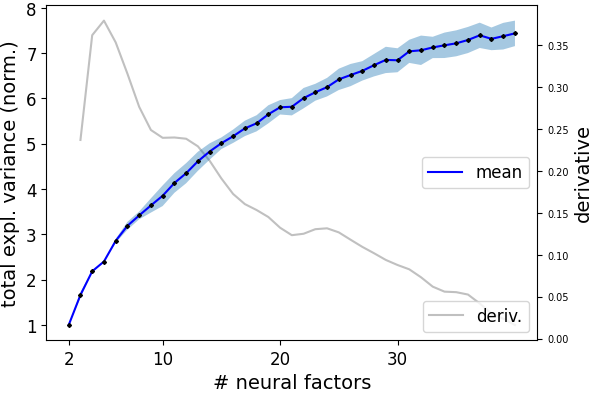

In [160]:
nfacs = np.array(Fs)
NEURALMODE = 0
mus = []

stds = []

LGD_SZ = 12
LBL_SZ = 14
TICK_SZ = 12

for nf in nfacs:
    #collect factors for all available repetitions
    neuralfs = np.array([preComputed[nf]['all_factors'][repi][NEURALMODE] for repi in sorted(preComputed[nf]['all_factors'])])
    #normalize
    neuralfs = [f/from0to1(np.linalg.norm(f,axis=0,keepdims=1)) for f in neuralfs]
    
    nucl_norms = []
    
    reps_used = list(preComputed[nf]['all_lambdas'])###
    
    for repi in range(len(preComputed[nf]['all_factors'])):

        A = neuralfs[repi].copy()
        Si = A.T
        Si -= Si.mean(0)
        #compute explained variances
        s = np.linalg.svd(Si,full_matrices=False,compute_uv=False)
        var = s**2/(Si.shape[0]-1)   
        #normalize
        var /= var.max()
        # compute nuclear norm (sum of eigenvals)
        nucl_norms.append( var.sum() )

    mus.append(np.mean(nucl_norms))
    stds.append(np.std(nucl_norms))

f,ax1 = subps(1,1,4,6)
ax1.plot(nfacs, mus,'b-', label='mean')
ax1.plot(nfacs, mus,'kD',markersize=2)

mus = np.array(mus)
grads = np.diff(gaussian_filter1d(mus,1.5))
ax1_ = ax1.twinx()
ax1_.plot(nfacs[1:],grads,c='silver',label='deriv.',zorder=0)
ax1_.set_ylabel('derivative',size=LBL_SZ)
ax1_.legend(loc="lower right",fontsize=LGD_SZ)
stds = np.array(stds)
ax1.fill_between(nfacs,mus-stds,mus+stds,alpha=.4)
ax1.set_xlabel('# neural factors',size=LBL_SZ)
ax1.set_ylabel('total expl. variance (norm.)',size=LBL_SZ)
ax1.set_xticks([2]+list(range(10,31,10)))
ax1.tick_params(labelsize=TICK_SZ)
ax1.legend(loc="center right",fontsize=LGD_SZ)
ax1.set_zorder(ax1_.get_zorder()+1)
ax1.set_frame_on(False)

plt.show()

In [161]:
print(optStims.count("hi"))

620


## Choose Number of Factors R

In [162]:
# just to throw an error to jump here for selecting the number of components to use
if R <= 0:
    set_R = True
    raise ValueError("R has to be > 0. Please set R in the next cell to an adequate value according to the above plot and run everything from here.")

else:
    set_R = False


ValueError: R has to be > 0. Please set R in the next cell to an adequate value according to the above plot and run everything from here.

In [163]:
##### Set R based on the plot above #####
if set_R:
    R = 14
    # i0=8, i1=11, i2=13, b0=12, b1=11, b2=11, rec=9, recout=12, pos=17, seed2=14

results_dict["R"] = R

rep, error = min(preComputed[R]['all_objs'].items(), key=lambda x: x[1])
print(f'The repetition with min error was #{rep} (% error = {error:.3f})')

The repetition with min error was #0 (% error = 9.262)


## Replot, highlighting for Factors R

/tmp/tmp.dmoYsEQfji/ipykernel_3709534/1867443850.py:2: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.

/tmp/tmp.dmoYsEQfji/ipykernel_3709534/1867443850.py:3: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "kD" (-> color='k'). The keyword argument will take precedence.

/tmp/tmp.dmoYsEQfji/ipykernel_3709534/1867443850.py:6: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.



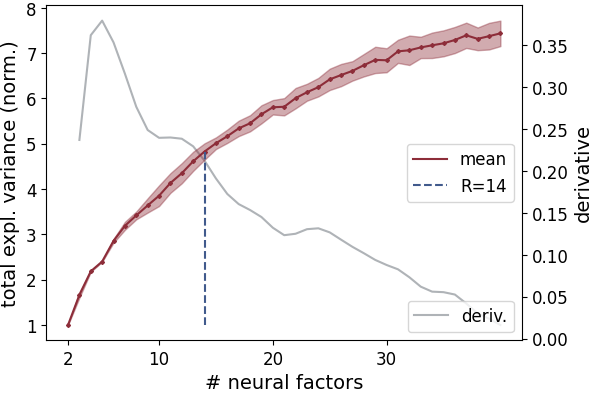

In [164]:
f,ax1 = subps(1,1,4,6)
ax1.plot(nfacs, mus,'b-', label='mean', color=rgb.tue_red)
ax1.plot(nfacs, mus,'kD',markersize=2, color=rgb.tue_red)

mus = np.array(mus)
ax1.plot([R,R],[mus.min(),mus[list(nfacs).index(R)]],'r--',label=f'R={R}',zorder=10, color=rgb.tue_darkblue)
grads = np.diff(gaussian_filter1d(mus,1.5))
ax1_ = ax1.twinx()
ax1_.plot(nfacs[1:],grads,c=rgb.tue_gray,label='deriv.',zorder=0)
ax1_.set_ylabel('derivative',size=LBL_SZ)
ax1_.legend(loc="lower right",fontsize=LGD_SZ)
stds = np.array(stds)
ax1.fill_between(nfacs,mus-stds,mus+stds,alpha=.4, color=rgb.tue_red)
ax1.set_xlabel('# neural factors',size=LBL_SZ)
ax1.set_ylabel('total expl. variance (norm.)',size=LBL_SZ)
ax1.set_xticks([2]+list(range(10,len(mus),10)))
ax1.tick_params(labelsize=TICK_SZ)
ax1_.tick_params(labelsize=TICK_SZ)
ax1.legend(loc="center right",fontsize=LGD_SZ)
ax1.set_zorder(ax1_.get_zorder()+1)
ax1.set_frame_on(False)

# save plot
plt.savefig(f'../fig/component_choices/{tensorname}_expl_var.png')
plt.show()

## Visualize Factors

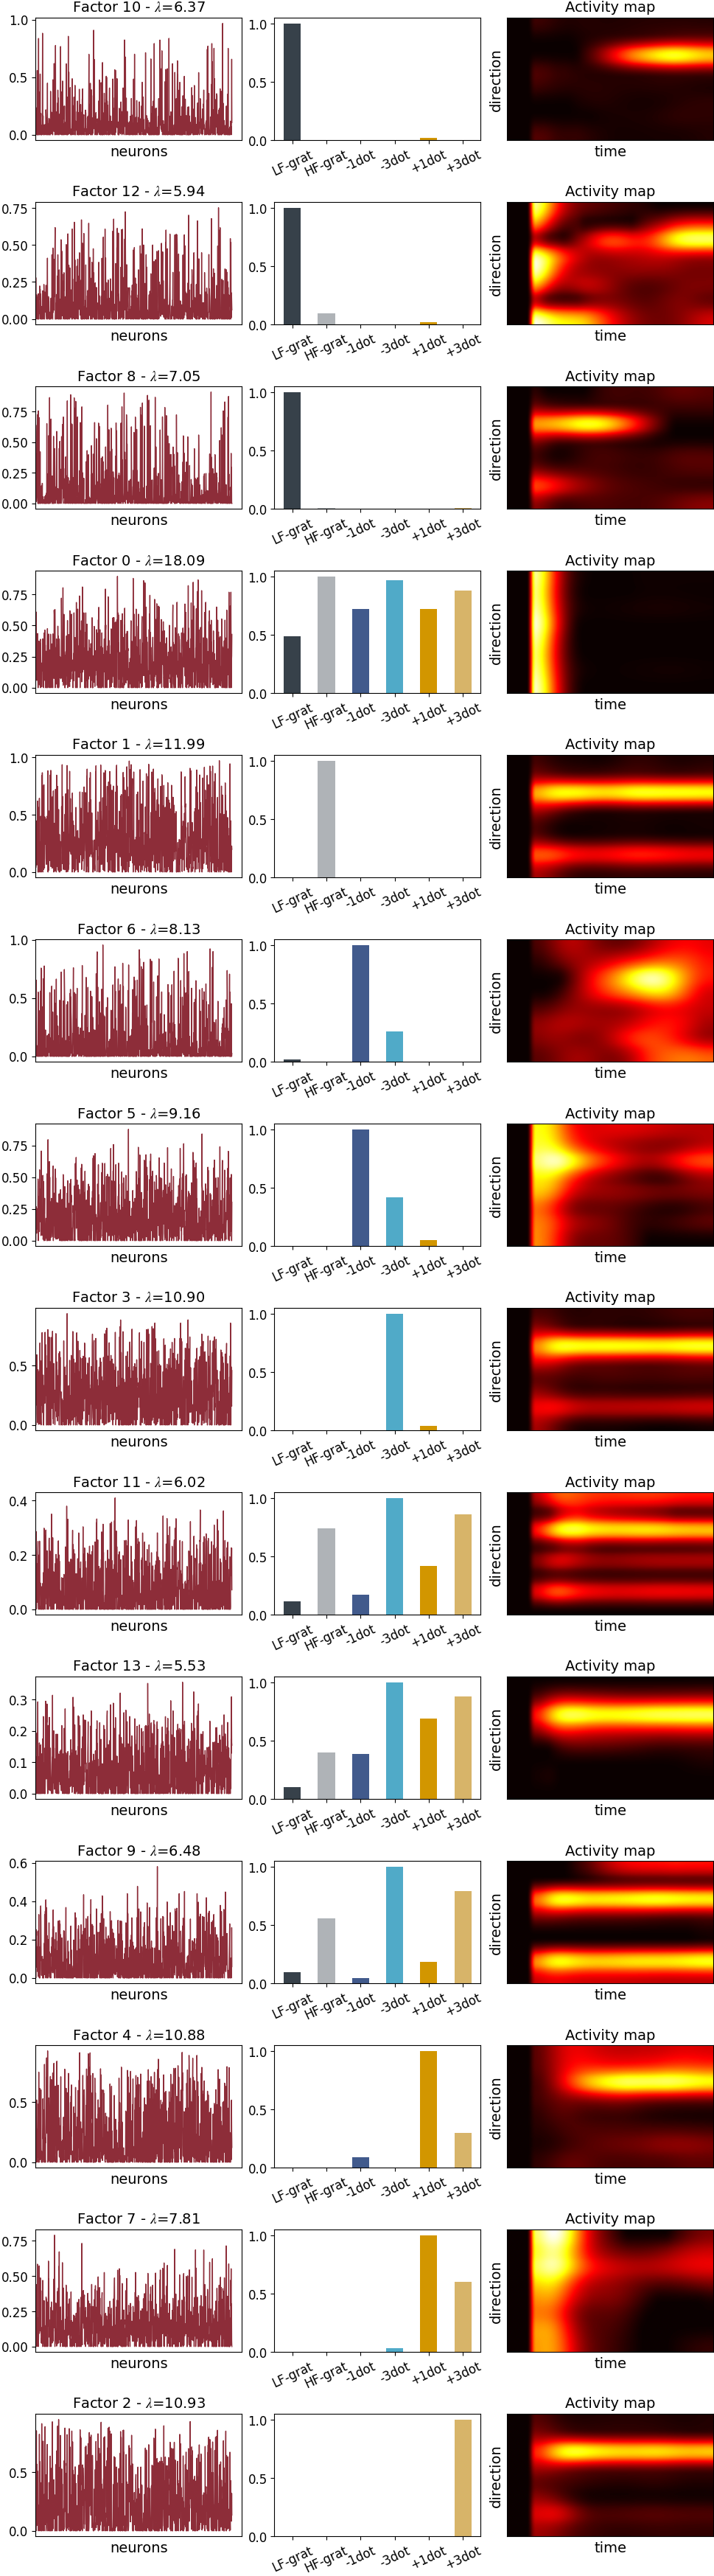

In [165]:
best_rep = 0
best_factors = preComputed[R]['all_factors'][best_rep]
best_lambdas = preComputed[R]['all_lambdas'][best_rep]

posnorms = ~np.isclose(best_lambdas,0)
best_lambdas = best_lambdas[posnorms]
nfactors = [f[:,posnorms]/np.linalg.norm(f[:,posnorms],axis=0,keepdims=1) for f in best_factors]

if optSF:
    my_stims = ['LF-grat', 'HF-grat', '-1dot', '-3dot', '+1dot', '+3dot']
else:
    my_stims = ['LF-grat', 'HF-grat', '-1dot', '-3dot', '+1dot', '+3dot', 'HF-grat', '-1dot', '-3dot', '+1dot', '+3dot']

NSTIMS = len(my_stims)
NDIRS = 8

leaves = range(nfactors[0].shape[0])

colors = [rgb.tue_dark, rgb.tue_gray, rgb.tue_darkblue, rgb.tue_lightblue, rgb.tue_orange, rgb.tue_lightorange, 'red', 'blue', 'yellow', 'green', 'pink']
assert len(colors) >= NSTIMS

ncols = 3; colsz = 3.25
nrows = R; rowsz = 2.5

#sort factors by predominant stim (%)
sorted_factors = np.argsort((nfactors[1]).argmax(axis=0))

#rebalance factor loadings, scale by lambdas
stim_factors = nfactors[1].copy()
stim_scls = stim_factors.max(0,keepdims=1)
stim_factors /= stim_scls

neural_factors = nfactors[0].copy()
neural_factors *= best_lambdas
neural_factors *= stim_scls

fig, axes = plt.subplots(len(neural_factors[0]), ncols, figsize=(colsz*ncols, len(neural_factors[0])*rowsz))

for ll,l in enumerate(sorted_factors):

    ax = axes[ll,0]
    ax.set_title(r'Factor %d - $\lambda$=%.2f' % (l,best_lambdas[l]),size=LBL_SZ)
    ax.plot(neural_factors[leaves,l],lw=1,c=rgb.tue_red)
    ax.set_xlim(0,ax.get_xlim()[1])
    ax.set_xticks([])
    ax.set_xlabel('neurons',size=LBL_SZ)
    ax.tick_params(axis='y', labelsize=TICK_SZ)
    
    ax = axes[ll,1]
    ax.bar(range(NSTIMS),stim_factors[:,l],width=.5,
            color=colors,tick_label=my_stims)

    ax.tick_params(axis='x', labelrotation=25, labelsize=TICK_SZ)
    ax.tick_params(axis='y', labelsize=TICK_SZ)
    

    ax = axes[ll,2]
    pst = nfactors[2][:,l].reshape(NDIRS,-1,order='F')
    # circular-shift response map to opt dir (for better visualization)
    opt_dir = pst.mean(1).argmax()
    pst = np.roll(pst,(2-opt_dir)%NDIRS,0)
    pst -= pst.min()
    # cosmetics: pad with zeros to mimic a "pre stimulus interval" when visualizing PSTHs
    pst = np.concatenate([np.zeros((NDIRS,5)),pst],axis=1)  
    ax.imshow(pst,aspect='auto',interpolation='quadric',cmap='hot')
    ax.set_title('Activity map', size=LBL_SZ)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('direction', size=LBL_SZ); ax.set_xlabel('time', size=LBL_SZ)
    

# save plot
plt.savefig(f'../fig/factor_activities/{tensorname}_factors.png')
plt.show()


## Data processing

nPCs=8


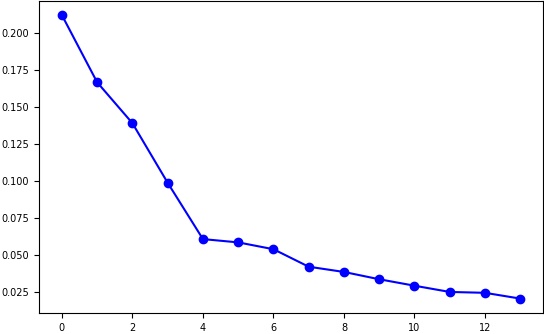

In [166]:
# remove any eventual zero-norm factor
posnorms = ~np.isclose(best_lambdas,0)
lambdas = best_lambdas[posnorms]
# make sure they are all normalized
factors = [f[:,posnorms]/np.linalg.norm(f[:,posnorms],axis=0,keepdims=1) for f in best_factors]

# find the permuted version of sigT that gave rise to the factors -- this is
# necessary for computing the actual rec error
sigT = tensorX
permT, fitT = getPermutedTensor(factors, lambdas, sigT, NDIRS)

all_zeroed_stims = None
scld_permT = permT #simplified for CNNs, since tensor was pre-scaled by FRs (see above)

X, all_scld_permT = getNeuralMatrix(
    scld_permT, factors, lambdas, NDIRS, all_zeroed_stims, order='F', verbose=False)

# optionally, eliminate possible redundancy among factors in the neural matrix using PCA
# (this is mostly used to ensure a more fair comparison across brain areas / networks, since they might use
# different numbers of tensor components)

MIN_EXPL_VAR_RATIO = 0.8

pca = PCA(len(lambdas))
pcaX = pca.fit_transform(X)

# number of PCs can be chosen based on a prespecified explained variance ratio,
nPCs = np.flatnonzero(np.cumsum(pca.explained_variance_ratio_) > MIN_EXPL_VAR_RATIO)[0] + 1
print(f'{nPCs=}')
results_dict["nPCs"] = nPCs

# or simply by inspection of the variance spectrum
plt.plot(pca.explained_variance_ratio_, 'bo-')
# nPCs = 

X = pcaX[:,:nPCs]

# compute matrix of squared distances
D2 = pwdists(X, sqdists=True)
N = D2.shape[0]

IndexError: index 1870 is out of bounds for axis 0 with size 1000

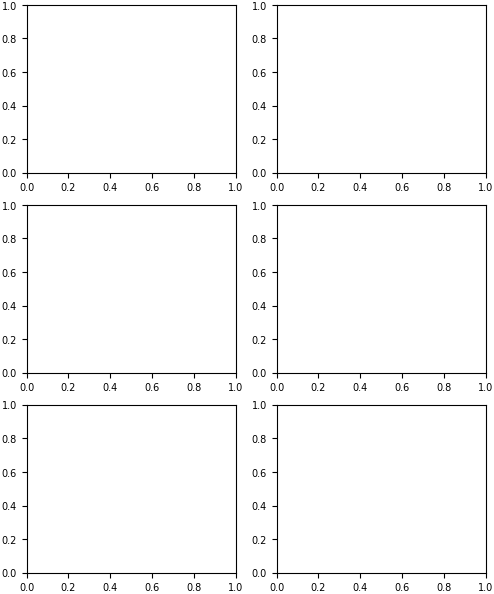

In [167]:
plot_permT = np.reshape(tensorX, (len(tensorX), 6, -1, 8))

start = 1500
stop = start + 50

neuron_idx = np.array([
    # FNN b2 inner
    #57, 95, 87, 1963, 730, 1831, 623, 635, 835, 738, 636, 638, 805, 821, 60, 1816, 808, 811, 801, 1826
    #380, 397, 371, 444, 371, 567, 361, 1312, 546, 1386, 387
    857, 894, 1870, 886, 37, 1864, 863, 885, 866, 1885, 1860, 859, 878, 1875, 852, 1862

    #AFNN l1
    #list(range(1550, 1600))
    #list(range(250, 300))
    #list(range(1500, 1550)) + list(range(1350, 1400))

    #AFNN l13
    #list(range(450, 500))
    #list(range(1900, 1950)) + list(range(650, 700))
    #list(range(1200, 1250)) + list(range(950, 1000))

    # AFNN rec
    #list(range(250, 300)) + list(range(900, 950))
    #list(range(350, 400))
    #list(range(0, 50)) #+ list(range(1300, 1350)) + list(range(1800, 1850)) 
    #list(range(1400, 1450))# + list(range(1950, 2000))

    # Resnet Block 1
    #list(range(275, 300))
    #list(range(650, 675))
    #list(range(475, 500)) + list(range(325, 350))
    #list(range(0, 25))

    # Resnet Block 4
    #list(range(925, 950))
    #451, 464, 456, 454, 466, 474, 458, 468, 471, 469, 462, 463, 46, 472, 473, 466, 454, 470, 220, 218, 222, 216, 217, 206, 204, 224, 211, 213, 37, 201, 44, 42, 26, 30, 32, 37
    #774, 753, 761, 758, 355, 90, 75, 82, 373, 99, 77, 752, 79, 769, 147, 148, 98, 767, 372, 354, 773, 764
    #71, 52, 53, 675, 690, 681, 698, 697, 677, 73, 66, 705, 196, 175, 72, 60, 56, 69, 417, 420


    # inputs 0
    
    #list(range(1050, 1100))
    #1512, 1614, 1802, 1644, 1350, 1977 # very left
    #1664, 1115, 1378, 1910, 244, 1485, 1442, 280, 833, 1941, 1947, 305, 1137, 1247, 338, 1046, 1902 # left

    #1870, 110, 100, 1502, 120, 1514, 1857 # very top
    #102, 1868, 138, 114, 1871, 1851, 134, 1878, 1856, 146, 139 # top
    #115, 149, 125, 105, 119, 129, 1886, 1879, 123 # top new arm
    #1092, 1093, 1095, 1072, 1073, 1082, 1084, 1085, 1059 # green full right
    #1173, 1151, 1185, 1165, 1172, 451, 1074, 1066, 1099, 1052, 1088, 1054, 1086, 1081, 1091, 1087, 1077, 1071, 1076, 1070, 1080, 1090 #greens right
    #list(range(1150, 1100)) + list(range(450, 500)) + list(range(0, 50))
    #218, 1820, 885, 884, 1544 #main cluster edge


    #list(range(start, stop))

    #PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_inputs1_maxFr_maxNr_seed1"
    #list(range(550, 600))
    #1551, 12, 306, 23, 7, 314, 333, 26, 18, 10, 303, 310, 328, 591, 1785, 92, 41, 42, 33, 864, 3, 318, 873, 862, 1597, 528, 558, 622, 59, 855, 343, 570, 5, 38, 897, 337, 889, 82, 334, 836, 332, 838, 76, 81, 305, 834, 1411, 894, 1012, 536, 868, 821, 1790, 344, 1113, 99, 510, 215, 1242, 1219, 602, 115, 1365, 1596, 519, 533, 1341, 809, 985, 943, 1572, 972, 524, 973, 950, 1477, 669, 812, 610, 1372, 800, 1244, 919, 531, 255, 816, 1386, 1309, 949, 1792, 1511, 282, 61, 262, 1526, 1704, 1499, 1380, 1798, 961, 804, 1128, 1384, 1394, 802, 1303, 207, 1335, 1642, 1336, 1250, 1816, 1137, 1306, 1087
    
    #PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_inputs2_maxFr_maxNr_seed1"
    #PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_blocks0_maxFr_maxNr_seed1"
    #PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_blocks1_maxFr_maxNr_seed1"

    #PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_blocks2_maxFr_maxNr_seed1" R=11
    #381, 374, 362, 363, 384, 356, 398# purple only lower left
    #10, 16, 9, 43, 0, 38, 41, 14, 12, 23 # pink
    #563, 597, 591, 592, 583, 574, 598 # orange
    #1842, 1838, 1814, 1824, 1826, 1802 # blue very top
    #1906, 1924, 1937, 1927, 1911, 1943, 1919, 1942, 1947, 1936, 1916, 1910, 1535 # light gray far
    #374, 362, 1135, 363, 689, 384, 1107, 1118, 1106, 1144, 1128, 1953, 688, 1881, 689, 356, 381 # lower left
    #686, 843, 1007, 805, 1995, 108, 662, 657, 671, 1995, 805, 1624, 1986, 1857, 1113, 804, 685, 1642, 1658 # lower right
    #1540, 1530, 1501, 1521, 1513, 1519, 1527, 1520, 1523, 1514, 1500, 1543, 1533, 1503, 1518, 1537, 1505, 1506, 1515 # dark gray
    #list(range(1900, 1950))[0] # grey cluster
    #133, 943, 1353, 128, 767, 112, 1709, 104, 107, 135, 761, 1726, 969, 589, 929, 105, 102, 556, 1606, 1608, 554, 1736, 407, 1729, 768, 1307, 1619, 927, 778, 1328, 1325, 1331, 118, 1334, 772, 701, 1368, 535, 575, 1320, 1314, 525, 562, 757, 920, 1607, 580, 246 # intensity spike
    #list(range(1700, 1750)) + list(range(1800, 1850))# blue/orange spike 
    #list(range(350, 400))[0] + list(range(1100, 1150))[0] + list(range(300, 350))[0] + list(range(650, 700))[0] # multi color spike


    #PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_hidden_maxFr_maxNr_seed1" R=9
    #1872, 1882, 1887, 1891, 1888, 1864, 1893, 1878, 1852, 926, 1897, 1851, 753, 1889, 1867, 1354, 788, 917, 937, 911, 1899, 1877 # grey
    #82, 92, 71, 61, 50, 77, 81 # pale yellow
    #235, 236, 210, 243, 212, 230, 246, 217, 239, 241, 204, 213, 206 # pale dark blue
    #1785, 1775, 1760, 1754, 1778, 1793, 1764, 1769, 1779, 1791 # blue
    #1802, 1838, 1833, 1845, 1834, 1832, 1815, 1847, 1825, 1842 # dark green
    #480, 497, 477, 483, 492, 471, 486, 478, 499, 485, 489, 454, 481, 496, 461, 459, 455, 466 # pale orange
    #1558, 1586, 1595, 1593, 1576, 1551, 1578, 1592, 1584, 1571, 1574, 1599, 1559, 1582, 1562 # orange
    #447, 416, 425, 413, 400, 421, 424, 410, 443, 1083, 1082, 1074, 1093, 1071, 1089, 1086, 427, 1065 # pinks
    #591, 553, 572, 578, 584, 557, 565, 573, 559, 571, 589, 555, 582, 595, 598, 579, 551, 590 # yellow


    #PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_recurrentout_maxFr_maxNr_seed1"

    #PREFIX = "fnn07_act_i3_n2000_SCL0_7_TL37_position_maxFr_maxNr_seed1" R=17
    #list(range(1150, 1200)) # pruple
    #list(range(650, 700)) # orange
    #list(range(1500, 1550)) # gray
    #list(range(1400, 1450)) # loght blue
    #list(range(850, 900)) # blue
    #list(range(100, 150)) # dark blue
    #list(range(1250, 1300)) # pink
    #list(range(600, 650)) # pale green
    #list(range(450, 500)) # dark orange
    #list(range(1600, 1650)) # light green 

    #PREFIX = "fnn07_seed2" R=14
    #772, 727, 694, 391, 903, 444, 538, 975, 655, 420, 336, 834, 41, 106, 628, 432, 131, 546, 848, 337, 428, 199, 794 # top spike
    #332, 576, 989, 378, 786, 887, 465, 477, 161, 653, 306, 901, 835, 32, 935, 348, 74, 480, 113, 118, 573, 87, 433, 431, 20, 150, 500, 787, 564, 86, 450, 39, 247, 820 #right/frotn
    #438, 422, 354, 823, 931, 550, 991, 239, 132, 512, 145, 559, 322, 894, 617, 845, 454, 246, 140, 234, 224, 613, 163, 760 # left bot
    #897, 157, 757, 504, 895, 383, 271, 604, 952, 453, 300, 138, 874, 457, 462, 933, 684, 508, 187, 167, 717, 463, 458 #left top

    #625, 75, 250, 713, 324, 706, 821, 710 # mini spike right
    #985, 826, 912, 942, 129, 579, 536, 769, 494, 56, 693, 934, 305, 222, 276, 319, 922, 929, 536 # bottom
    #212, 204, 42, 518, 674, 813, 447, 562, 26, 164, 616, 29, 642 # top behind

    # new block 2 seed 2
    #57, 95, 1963, 849, 730, 87, 1831, 738, 623, 821, 835, 636, 840, 811, 844 #front
    #1386, 567, 434, 1381, 1232, 263, 1374 #bottom
    #1779, 1759, 1796, 1771, 1171, 1355, 1841, 1214, 1423, 1953, 1973, 1457, 1091# right
    #list(range(850, 900)) # gray right
    #1582, 978, 687, 1729, 959, 983, 1176, 1107, 1546, 240, 1523 # top

    # minimodls l2
    #658, 698, 678, 925, 265, 283, 910, 1431, 1588, 1402, 1377
]).squeeze()



fig, axs = plt.subplots(3, 2, figsize=(5, 6))
for stim in range(6):
    pst_orig = np.mean(plot_permT[neuron_idx, stim, :, :], axis=0).T
    print(pst_orig.shape)
    pst = np.zeros((pst_orig.shape[0], pst_orig.shape[1] + 5))
    pst[:, 5:] = pst_orig
    opt_dir = pst.mean(1).argmax()
    pst = np.roll(pst, (2-opt_dir)%8, 0)
    axs[stim//2, stim%2].imshow(pst, aspect='auto', interpolation='quadric', cmap='hot')
    axs[stim//2, stim%2].xaxis.set_visible(False)
    axs[stim//2, stim%2].yaxis.set_visible(False)

#fig.suptitle(f"Neuron {neuron_idx}", fontsize=16)

plt.tight_layout()
plt.show()

In [168]:
"""#neuron_idx = [296]
#neuron_idx = [952]
#neuron_idx = [16]
#neuron_idx = [211]
#neuron_idx = [548]
#neuron_idx = [737]
#neuron_idx = [528]
#neuron_idx = [655]
#neuron_idx = [772]

#neuron_idx = [958]
#neuron_idx = [828]
#neuron_idx = [673]
#neuron_idx = [660]
#neuron_idx = [281]
#neuron_idx = [86]
#neuron_idx = [858]

#neuron_idx = [870]
neuron_idx = [376]
#neuron_idx = [813]
#neuron_idx = [1759]
#neuron_idx = [1355]
#neuron_idx = [86]
#neuron_idx = [579]

fig, axs = plt.subplots(3, 2, figsize=(5, 6))
for stim in range(6):
    pst_orig = np.mean(plot_permT[neuron_idx, stim, :, :], axis=0).T
    print(pst_orig.shape)
    pst = np.zeros((pst_orig.shape[0], pst_orig.shape[1] + 5))
    pst[:, 5:] = pst_orig
    opt_dir = pst.mean(1).argmax()
    pst = np.roll(pst, (2-opt_dir)%8, 0)
    axs[stim//2, stim%2].imshow(pst, aspect='auto', interpolation='quadric', cmap='hot')
    axs[stim//2, stim%2].xaxis.set_visible(False)
    axs[stim//2, stim%2].yaxis.set_visible(False)

#fig.suptitle(f"Neuron {neuron_idx}", fontsize=16)

plt.tight_layout()
plt.show()"""

'#neuron_idx = [296]\n#neuron_idx = [952]\n#neuron_idx = [16]\n#neuron_idx = [211]\n#neuron_idx = [548]\n#neuron_idx = [737]\n#neuron_idx = [528]\n#neuron_idx = [655]\n#neuron_idx = [772]\n\n#neuron_idx = [958]\n#neuron_idx = [828]\n#neuron_idx = [673]\n#neuron_idx = [660]\n#neuron_idx = [281]\n#neuron_idx = [86]\n#neuron_idx = [858]\n\n#neuron_idx = [870]\nneuron_idx = [376]\n#neuron_idx = [813]\n#neuron_idx = [1759]\n#neuron_idx = [1355]\n#neuron_idx = [86]\n#neuron_idx = [579]\n\nfig, axs = plt.subplots(3, 2, figsize=(5, 6))\nfor stim in range(6):\n    pst_orig = np.mean(plot_permT[neuron_idx, stim, :, :], axis=0).T\n    print(pst_orig.shape)\n    pst = np.zeros((pst_orig.shape[0], pst_orig.shape[1] + 5))\n    pst[:, 5:] = pst_orig\n    opt_dir = pst.mean(1).argmax()\n    pst = np.roll(pst, (2-opt_dir)%8, 0)\n    axs[stim//2, stim%2].imshow(pst, aspect=\'auto\', interpolation=\'quadric\', cmap=\'hot\')\n    axs[stim//2, stim%2].xaxis.set_visible(False)\n    axs[stim//2, stim%2].yaxi

## Outlier analysis - visualizing distance distributions and potential outliers

Outliers (most distant): 446,413,670,878,236,7,679,202,533
Original indices: 446,413,670,878,236,7,679,202,533
Outliers (most similar): 78,890,397,523,473,847,389,608,987,45
Original indices: 78,890,397,523,473,847,389,608,987,45


/tmp/tmp.dmoYsEQfji/ipykernel_3709534/4274475753.py:56: UserWarning:

The figure layout has changed to tight



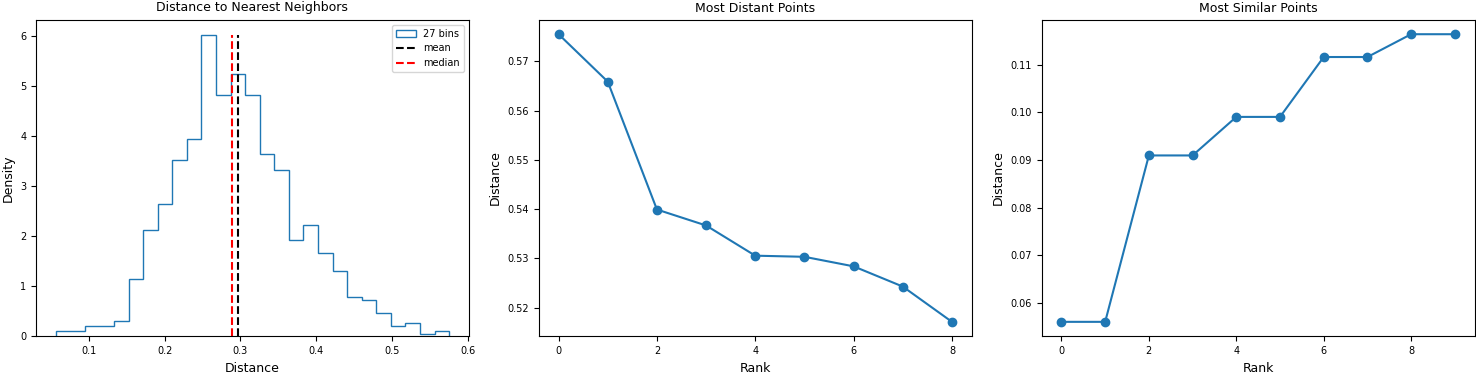

In [169]:
# especially for CNNs, it's a good idea to remove any obvious outliers before running IAN
nonoutliers = np.arange(D2.shape[0])
# this histogram of distance to nearest nbrs helps identifying them (if present)
# wanna remove points that have either this 1-NN distance too close to 0 (e.g. two neurons that had near zero response to everything)
# or neurons that were too different than everything else

D1 = np.sqrt(D2)
mindists = np.min(D1 + np.eye(N)*D1.max(),axis=0)
meanmind = mindists.mean()
medianmind = np.median(mindists)

# Create subplots to show outlier analysis together
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram of minimum distances
for n_bins in ['fd']:#,'doane','stone']:
    if type(n_bins) is str:
        try:
            bin_edges = np.histogram_bin_edges(mindists,n_bins)
        except:
            continue
        n_bins = len(bin_edges)-1
    counts,edges,_ = axes[0].hist(mindists,n_bins,histtype='step',density=True,label=f'{n_bins} bins')
axes[0].plot([meanmind,meanmind],[0,counts.max()],'k--',label='mean')
axes[0].plot([medianmind,medianmind],[0,counts.max()],'r--',label='median')
axes[0].legend()
axes[0].set_title('Distance to Nearest Neighbors')
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Density')

# Check indices of points that might be too far away from all other points
mean_dists = mindists
n = 9
axes[1].plot(sorted(mean_dists)[::-1][:n])
axes[1].scatter(range(n),sorted(mean_dists)[::-1][:n])
axes[1].set_xticks(range(0,n,2))
axes[1].set_title('Most Distant Points')
axes[1].set_xlabel('Rank')
axes[1].set_ylabel('Distance')
outls = np.argsort(mean_dists)[::-1][:n]
print('Outliers (most distant):',','.join(map(str,outls)))
print('Original indices:',','.join(map(str,nonoutliers[outls])))

# ... and check for points that might be way too close to one another (nearly-identical)
n_close = 10
axes[2].plot(sorted(mean_dists)[:n_close])
axes[2].scatter(range(n_close),sorted(mean_dists)[:n_close])
axes[2].set_xticks(range(0,n_close,2))
axes[2].set_title('Most Similar Points')
axes[2].set_xlabel('Rank')
axes[2].set_ylabel('Distance')
outls_close = np.argsort(mean_dists)[:n_close]
print('Outliers (most similar):',','.join(map(str,outls_close)))
print('Original indices:',','.join(map(str,nonoutliers[outls_close])))

plt.tight_layout()
plt.show()


In [170]:
a=b

NameError: name 'b' is not defined

In [171]:
too_far = nonoutliers[outls][:3] # check idxs of a few most faraway points
too_close = nonoutliers[outls_close][:37] # check idxs of a few points that are almost identical to discard
#too_far_2 = [1096, 1097]

# build a short list of potential outliers and remove them from the analysis -- this can greatly improve the visualization
outliers_list = np.append(too_far, too_close)

myX = X[[c for c in range(X.shape[0]) if c not in outliers_list]]
# keep track of original idxs of the actual neurons being used
nonoutliers = np.array([i for i in range(X.shape[0]) if i not in outliers_list])

# compute matrix of squared distances
D2 = pwdists(myX, sqdists=True)

# save the processed data
np.save(f'../data/sq_dists/D2_{tensorname}.npy', D2)

# update N
N = D2.shape[0]

## Run IAN

### Iteration 1 done. (4.66 s) - pruned 3 edge(s)
### Iteration 2 done. (0.87 s) - pruned 3 edge(s)
### Iteration 3 done. (0.80 s) - pruned 3 edge(s)
### Iteration 4 done. (0.80 s) - pruned 3 edge(s)
### Iteration 5 done. (0.82 s) - pruned 3 edge(s)
### Iteration 6 done. (0.82 s) - pruned 3 edge(s)
### Iteration 7 done. (0.85 s) - pruned 3 edge(s)
### Iteration 8 done. (0.92 s) - pruned 3 edge(s)
### Iteration 9 done. (0.81 s) - pruned 3 edge(s)
### Iteration 10 done. (0.86 s) - pruned 3 edge(s)
### Iteration 11 done. (0.82 s) - pruned 3 edge(s)
### Iteration 12 done. (0.79 s) - pruned 3 edge(s)
### Iteration 13 done. (0.83 s) - pruned 2 edge(s)
### Iteration 14 done. (0.75 s) - pruned 2 edge(s)
### Iteration 15 done. (0.79 s) - pruned 2 edge(s)
### Iteration 16 done. (0.79 s) - pruned 2 edge(s)
### Iteration 17 done. (0.79 s) - pruned 2 edge(s)
### Iteration 18 done. (0.78 s) - pruned 2 edge(s)
### Iteration 19 done. (0.78 s) - pruned 2 edge(s)
### Iteration 20 done. (0.78 s) - pruned

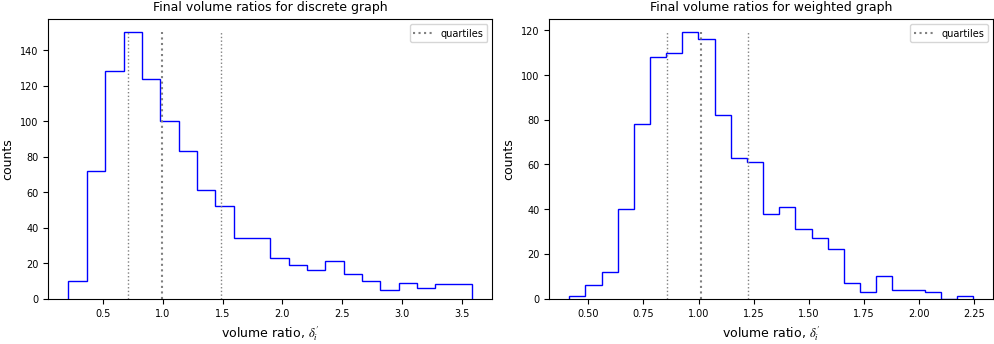

In [172]:
#solver = 'GUROBI' #using a commercial optimization package is highly recommended for faster kernel convergence.
# A free academic license can be obtained at https://www.gurobi.com/academia/academic-program-and-licenses/

# use None if you don't have a preferred solver, or pick from the list of solvers from cvxpy: 
# https://www.cvxpy.org/tutorial/advanced/index.html#choosing-a-solver
# This is usually fine for moderate sized datasets.
solver = None 

G, wG, optScales, disc_pts = IAN('exact-precomputed-sq', D2, solver=solver)
#G, wG, optScales, disc_pts = IAN('approximate', D2, solver=solver)

# Optional: instead of picking a single decomposition result, can compute separate graphs for each initialization and
# average them together to combine all results into a single weighted graph.

save_dense = wG.toarray()
np.save(f"../data/wG/{PREFIX}_{R}.npy", save_dense)

## Graph Analysis

In [173]:
#wG = np.load("../data/similarity-3.npy")

In [174]:
# Compute graph connectivity statistics
graph_stats = compute_graph_statistics(wG, neurons_used, nonoutliers)

# Extract individual lists for backward compatibility
degrees = graph_stats['degrees']
weighted_degrees = graph_stats['weighted_degrees']
same_fmaps = graph_stats['same_fmaps']
other_fmaps = graph_stats['other_fmaps']

# Update results dictionary with graph statistics
for key in ['degree_mean', 'degree_min', 'degree_max', 'degree_std',
            'weighted_degree_mean', 'weighted_degree_min', 'weighted_degree_max', 'weighted_degree_std',
            'same_fmap_mean', 'same_fmap_min', 'same_fmap_max', 'same_fmap_std',
            'other_fmap_mean', 'other_fmap_min', 'other_fmap_max', 'other_fmap_std']:
    results_dict[key] = graph_stats[key]

print(f"Mean of degrees = {graph_stats['degree_mean']}")
print(f"Min of degrees = {graph_stats['degree_min']}")
print(f"Max of degrees = {graph_stats['degree_max']}")
print(f"Std of degrees = {graph_stats['degree_std']}\n")
print(f"Mean of weighted degrees = {graph_stats['weighted_degree_mean']}")
print(f"Min of weighted degrees = {graph_stats['weighted_degree_min']}")
print(f"Max of weighted degrees = {graph_stats['weighted_degree_max']}")
print(f"Std of weighted degrees = {graph_stats['weighted_degree_std']}\n")
print(f"Mean number of connections to same fmap neurons = {graph_stats['same_fmap_mean']}")
print(f"Min number of connections to same fmap neurons = {graph_stats['same_fmap_min']}")
print(f"Max number of connections to same fmap neurons = {graph_stats['same_fmap_max']}")
print(f"Std number of connections to same fmap neurons = {graph_stats['same_fmap_std']}\n")
print(f"Mean number of connections to other fmap neurons = {graph_stats['other_fmap_mean']}")
print(f"Min number of connections to other fmap neurons = {graph_stats['other_fmap_min']}")
print(f"Max number of connections to other fmap neurons = {graph_stats['other_fmap_max']}")
print(f"Std number of connections to other fmap neurons = {graph_stats['other_fmap_std']}")

# Handle disconnected points from IAN optimization
wG, G, outliers_list, nonoutliers, nonout_mask = handle_disconnected_points(
    disc_pts, optScales, G, D2, outliers_list, neurons_used, X)

print(f"Number of disconnected points: {len([disc_pts[di][0] for di in range(len(disc_pts))])}")
print(f"Total outliers: {len(outliers_list)}")
print(f"Remaining points: {len(nonoutliers)}")

Mean of degrees = 949.1347517730496
Min of degrees = 388
Max of degrees = 986
Std of degrees = 67.69027052256938

Mean of weighted degrees = 20.128814861300313
Min of weighted degrees = 2.0022072390484653
Max of weighted degrees = 62.62188821162124
Std of weighted degrees = 9.504610147934317

Mean number of connections to same fmap neurons = 949.1347517730496
Min number of connections to same fmap neurons = 388
Max number of connections to same fmap neurons = 986
Std number of connections to same fmap neurons = 67.69027052256938

Mean number of connections to other fmap neurons = 0.0
Min number of connections to other fmap neurons = 0
Max number of connections to other fmap neurons = 0
Std number of connections to other fmap neurons = 0.0
Number of disconnected points: 0
Total outliers: 13
Remaining points: 987


## Plot 2D Manifold

/tmp/tmp.dmoYsEQfji/ipykernel_3709534/2125941366.py:39: UserWarning:

The figure layout has changed to tight



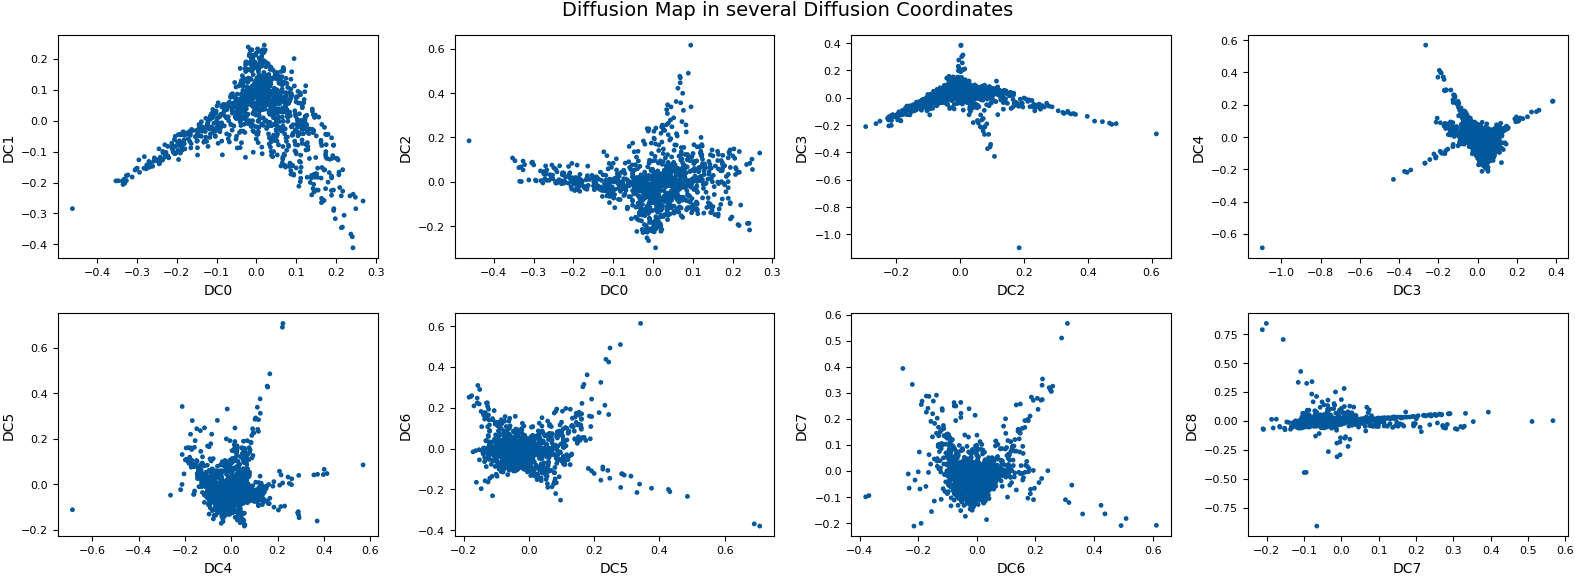

In [175]:
# Colors to differentiate clusters in the diffusion map
palstr = np.array([
    '#03579b', '#0488d1', '#03a9f4', '#4fc3f7', '#b3e5fc', 
    '#19237e', '#303f9f', '#3f51b5', '#7986cb', '#c5cae9', 
    '#4a198c', '#7b21a2', '#9c27b0', '#ba68c8', '#e1bee7', 
    '#88144f', '#c21f5b', '#e92663', '#f06292', '#f8bbd0', 
    '#bf360c', '#e64a18', '#ff5722', '#ff8a65', '#ffccbc', 
    '#f67f17', '#fbc02c', '#ffec3a', '#fff177', '#fdf9c3', 
    '#33691d', '#689f38', '#8bc34a', '#aed581', '#ddedc8',  
    '#253137', '#455a64', '#607d8b', '#90a4ae', '#cfd8dc'
])
from scipy.sparse import csr_matrix
diffmap_y, diffmap_evals = diffusionMapSparseK(csr_matrix(wG), 20, 1, t=1)

c = neurons_used[nonoutliers,1] # labels for the different feature maps
#c = neurons_used[:60, 1]

ulbls, labels = np.unique(c,return_inverse=True)

repeat = np.max(labels) // 40 + 1
palstr = np.repeat(palstr, repeat)

cluster_colors = [palstr[li] for li in labels]

# flip thru diff coords to see the multiple clusters (usually strongly associated with a specific feature map)
DCs = [(0,1), (0,2), (2,3), (3,4),
      (4,5), (5,6), (6,7), (7,8)]

PCs = diffmap_y

f, axes = subps(2, len(DCs)//2, 3, 4)

for ax, (dci, dcj) in zip(axes.ravel(), DCs):
    ax.scatter(*diffmap_y[:,[dci, dcj]].T,c=cluster_colors,s=6)
    ax.set_xlabel(f'DC{dci}', size=LBL_SZ-4)
    ax.set_ylabel(f'DC{dcj}', size=LBL_SZ-4)
    ax.tick_params(labelsize=TICK_SZ-4)
f.suptitle("Diffusion Map in several Diffusion Coordinates", size=LBL_SZ)
f.tight_layout()

plt.savefig(f'../fig/manifolds/{tensorname}_{R}_diffmaps.png')

plt.show()

In [176]:
from scipy.spatial.distance import pdist, squareform

distances = squareform(pdist(diffmap_y, metric='euclidean'))
max_distance = np.max(distances)
similarity_matrix = 1 - distances / max_distance

np.save(f"../data/diff_similarity/{PREFIX}_{R}.npy", similarity_matrix)

## Compute MDS embedding for better visualization

In [177]:
embedding_ = compute_mds_embedding(diffmap_y, nPCs, n_components=10)

## Run HDBSCAN clustering to estimate number of clusters

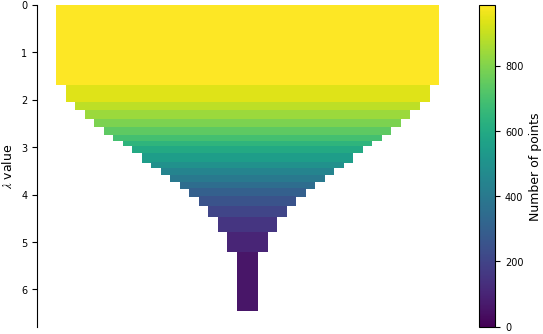

In [178]:
cluster_labels, num_clusters, cond_tree, hdbscan_leaves = run_hdbscan_clustering(diffmap_y, nPCs, G, min_cluster_size=10)

# Display results
cond_tree.plot(select_clusters=True)
results_dict["hdbscan_clusters"] = num_clusters

# Save the plot 
plt.savefig(f'../fig/dendrograms/{tensorname}_{R}_clusters{num_clusters}_hdbscan.png')

## Plot 3D Manifold

In [179]:
# embedding to be plotted
#N, NSTIMS, NDIRS, TRIAL_LEN = tensor4d.shape

Y = embedding_

# pick 3 coords to plot
dcs = [0,1,2]

fig = go.Figure()
traces = []

#color palette
mypal = palstr

colors = neurons_used[nonoutliers,1]
#colors = neurons_used[:60, 1]
fmapis = np.unique(colors)

while len(mypal) < len(fmapis):
    mypal = np.r_[mypal,mypal]

mypal = mypal[np.arange(0,len(mypal),len(mypal)//len(fmapis))]

hovertext = np.array(list(map(str,nonoutliers)))
#hovertext = np.array(list(map(str,list(range(60)))))
#print(hovertext)
#print(len(hovertext))

for fi,fmapi in enumerate(fmapis):
    color_mask = colors==fmapi
    traces.append(go.Scatter3d(
        x=Y[color_mask,dcs[0]],
        y=Y[color_mask,dcs[1]],
        z=Y[color_mask,dcs[2]],
        mode='markers',
        name='',
        hoverinfo='text',
        hovertext=hovertext[color_mask],
        marker=dict(
            size=4,
            color=mypal[fi],
            opacity=0.8,
        )))

for trace in traces:
    fig.add_trace(trace)
radius = .5
dcranges = [(-radius,radius)]*3
dcranges = [None]*3
axis_visible = True
showDClbl = True

fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0),
    showlegend=False, 
    template="plotly_white",
    scene=dict(
        xaxis=dict(
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True,
            showticklabels=False,
            ticks='',
            title=''
        ),
        yaxis=dict(
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True,
            showticklabels=False,
            ticks='',
            title=''
        ),
        zaxis=dict(
            showline=True,
            linewidth=2,
            linecolor='black',
            mirror=True,
            showticklabels=False,
            ticks='',
            title=''
        )
    )
)

#save figure
fig.write_html(f'../fig/3d_manifolds/{tensorname}_{R}_diffmap.html')
fig.write_html(f'../fig_paper/3d_manifolds_{tensorname}_{R}.html')
fig.show()

In [180]:
57, 95, 87, 1963, 730, 1831, 623, 635, 835, 738, 636, 638, 805, 821, 60, 1816, 808, 811, 801, 1826
380, 397, 371, 444, 371, 567, 361, 1312, 546, 1386, 387
857, 894, 1870, 886, 37, 1864, 863, 885, 866, 1885, 1860, 859, 878, 1875, 852, 1862

(857,
 894,
 1870,
 886,
 37,
 1864,
 863,
 885,
 866,
 1885,
 1860,
 859,
 878,
 1875,
 852,
 1862)

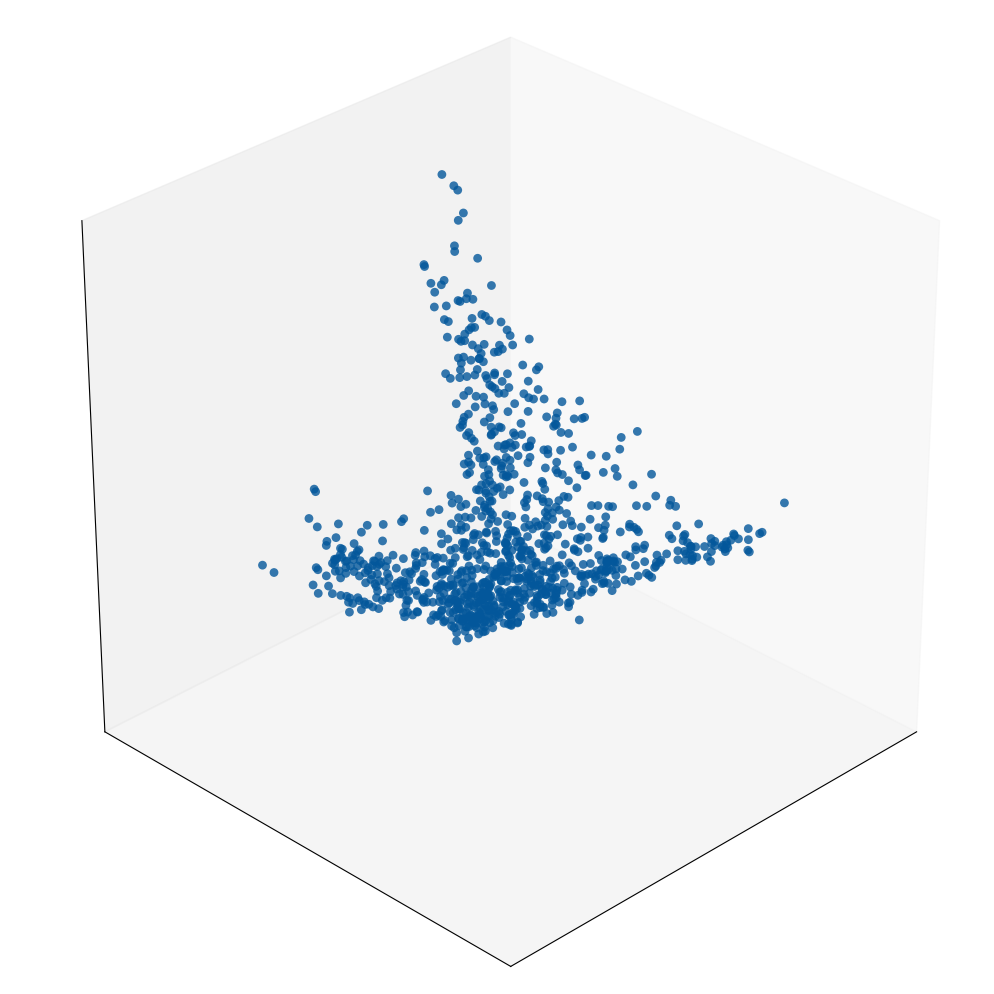

Saved vector graphic to: ../pdfs/fnn07_seed2-relNorm_sig3_n1000_SF-deepnet-shift_14_diffmap.pdf


In [197]:

# --- 1. Setup Data & Colors (Matching your logic) ---
# Ensure mypal is a numpy array for the concatenation logic to work
mypal = np.array(palstr) 
colors = neurons_used[nonoutliers, 1]
fmapis = np.unique(colors)

# Replicate the palette extension logic
while len(mypal) < len(fmapis):
    mypal = np.r_[mypal, mypal]

# Subsample the palette
mypal = mypal[np.arange(0, len(mypal), len(mypal) // len(fmapis))]

# --- 2. Initialize Figure ---
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# --- 3. Plotting Loop ---
for fi, fmapi in enumerate(fmapis):
    color_mask = colors == fmapi
    
    # Plotly size=4 is roughly area~16 in Matplotlib (s is points^2)
    # We use s=20 for visibility
    ax.scatter(
        Y[color_mask, dcs[0]],
        Y[color_mask, dcs[1]],
        Y[color_mask, dcs[2]],
        c=mypal[fi],       # Use the calculated palette color
        s=40,              # Marker size
        alpha=0.8,         # Opacity
        edgecolors='none', # Remove outlines for cleaner clusters
        depthshade=False   # Match Plotly's "flat" color (no distance fading)
    )

# --- 4. Styling (Clean "Plotly White" imitation) ---

# Remove gray background panes
#ax.xaxis.pane.fill = False
#ax.yaxis.pane.fill = False
#ax.zaxis.pane.fill = False

# Remove grid lines
ax.grid(False)

# Remove tick labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Style the axis lines (Spines) to be black and visible
ax.xaxis.line.set_color('black')
ax.yaxis.line.set_color('black')
ax.zaxis.line.set_color('black')

# Optional: Enforce a cubic aspect ratio so the manifold isn't distorted
ax.set_box_aspect([1, 1, 1])

ax.view_init(elev=30, azim=45)

# --- 5. Save as PDF ---
output_path = f'../pdfs/{tensorname}_{R}_diffmap.pdf'
plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=300)
plt.show()
plt.close(fig)

print(f"Saved vector graphic to: {output_path}")

## Advanced Analysis

Additional analyses including factor visualization on manifolds, local dimension estimation, orientation selectivity calculations, neighborhood analysis, and metrics export for deeper insights into neural response properties.

**Note:** The advanced analysis sections below are controlled by the `run_advanced_analysis` parameter. Set it to `True` to execute these computationally intensive analyses.

In [182]:
run_advanced_analysis = False

In [183]:
# Check if advanced analysis should be run
if not run_advanced_analysis:
    print("Advanced analysis is disabled. Set run_advanced_analysis=True to enable.")
else:
    print("Running advanced analysis...")


Advanced analysis is disabled. Set run_advanced_analysis=True to enable.


In [184]:
if run_advanced_analysis:
    def histogram_entropy(activations, bins=10000):
        counts, _ = np.histogram(activations, bins=bins)
        probs = counts / np.sum(counts)
        
        # Remove zero probabilities
        probs = probs[probs > 0]
        
        entropy = -np.sum(probs * np.log(probs))
        return entropy
    print(neural_factors.shape)
    entropies = []
    dists = []
    for factor in range(len(neural_factors[0])):
        entropies.append(histogram_entropy(neural_factors[:, factor]))

        previous_facts = neural_factors[:-1, factor]
        next_facts = neural_factors[1:, factor]

        dists.append(np.mean(next_facts - previous_facts))

    results_dict["entropy"] = np.mean(entropies)
    results_dict["factor_dists"] = np.mean(dists)
    print(np.mean(entropies))
    print(np.mean(dists))


    


## 2D Manifold colored by Clusters

In [185]:
if run_advanced_analysis:
    hdb_palstr = np.append(palstr, palstr)

    cluster_colors = [hdb_palstr[li] for li in cluster_labels]

    # flip thru diff coords to see the multiple clusters (usually strongly associated with a specific feature map)
    #DCs = [(0,1), (0,2)]
    DCs = [(0,1), (0,2), (2,3), (3,4),
          (4,5), (5,6), (6,7), (7,8)]

    PCs = embedding_

    f, axes = subps(2, len(DCs)//2)

    for ax, (dci, dcj) in zip(axes.ravel(), DCs):
        ax.scatter(*PCs[:,[dci, dcj]].T,c=cluster_colors,s=6)
        ax.set(xlabel=f'DC{dci}', ylabel=f'DC{dcj}')
    f.tight_layout()
    plt.savefig(f'../fig/manifolds/{tensorname}_{R}_diffmaps_by_cluster.png')
    plt.show()

## OSI and Preferred Stimulus Colored 3D Manifold

In [186]:
if run_advanced_analysis:
    # Calculate OSI and preferred stimulus using utility function
    OSI_final, pref_stim = compute_osi_and_pref_stim(tensorX)

    # Define 6 discrete colors for pref stim (can be customized)
    pref_colors = [
        "#0070C0",  # red
        "#00B0F0",  # blue
        "#00B050",  # green
        "#92D050",  # orange
        "#FF0000",  # purple
        "#FFC000",  # yellow
    ]

    for to_plot in ["osi", "pref_stim"]:
        Y = embedding_
        dcs = [0, 1, 2]

        if to_plot == "pref_stim":
            factor_values = pref_stim[nonoutliers]
            # Map pref_stim values to 0-5 for color assignment
            pref_stim_labels = np.asarray(factor_values, dtype=int)
            # If pref_stim is not already 0-5, remap as needed:
            # unique_vals = np.unique(pref_stim_labels)
            # label_map = {val: i for i, val in enumerate(unique_vals)}
            # pref_stim_labels = np.vectorize(label_map.get)(pref_stim_labels)
            color_vals = [pref_colors[i % 6] for i in pref_stim_labels]

            fig = go.Figure()
            scatter = go.Scatter3d(
                x=Y[:, dcs[0]],
                y=Y[:, dcs[1]],
                z=Y[:, dcs[2]],
                mode='markers',
                hoverinfo='text',
                hovertext=np.array(list(map(str, nonoutliers))),
                marker=dict(
                    size=6,
                    color=color_vals,
                    opacity=0.8,
                    line=dict(width=0),
                ),
            )
            fig.add_trace(scatter)
            fig.update_layout(
                margin=dict(l=0, r=0, b=0, t=0),
                showlegend=False, 
                template="plotly_white",
                scene=dict(
                    xaxis=dict(
                        showline=True,
                        linewidth=2,
                        linecolor='black',
                        mirror=True,
                        showticklabels=False,
                        ticks='',
                        title=''
                    ),
                    yaxis=dict(
                        showline=True,
                        linewidth=2,
                        linecolor='black',
                        mirror=True,
                        showticklabels=False,
                        ticks='',
                        title=''
                    ),
                    zaxis=dict(
                        showline=True,
                        linewidth=2,
                        linecolor='black',
                        mirror=True,
                        showticklabels=False,
                        ticks='',
                        title=''
                    )
                )
            )
            # Add a custom legend for the 6 classes
            for i, color in enumerate(pref_colors):
                fig.add_trace(go.Scatter3d(
                    x=[None], y=[None], z=[None],
                    mode='markers',
                    marker=dict(size=8, color=color),
                    name=f"Stim {i+1}"
                ))
            #fig.show()
            fig.write_html(f'../fig_paper/stim_{tensorname}_{R}.html')

        if to_plot == "osi":
            factor_values = OSI_final[nonoutliers]
            fig = go.Figure()
            scatter = go.Scatter3d(
                x=Y[:, dcs[0]],
                y=Y[:, dcs[1]],
                z=Y[:, dcs[2]],
                mode='markers',
                hoverinfo='text',
                hovertext=np.array(list(map(str, nonoutliers))),
                marker=dict(
                    size=6,
                    color=factor_values,
                    colorscale='Viridis',
                    opacity=0.8,
                    colorbar=dict(
                        title="OSI",
                        thickness=20,
                    ),
                    showscale=True,
                ),
            )
            fig.add_trace(scatter)
            fig.update_layout(
                margin=dict(l=0, r=0, b=0, t=0),
                showlegend=False, 
                template="plotly_white",
                scene=dict(
                    xaxis=dict(
                        showline=True,
                        linewidth=2,
                        linecolor='black',
                        mirror=True,
                        showticklabels=False,
                        ticks='',
                        title=''
                    ),
                    yaxis=dict(
                        showline=True,
                        linewidth=2,
                        linecolor='black',
                        mirror=True,
                        showticklabels=False,
                        ticks='',
                        title=''
                    ),
                    zaxis=dict(
                        showline=True,
                        linewidth=2,
                        linecolor='black',
                        mirror=True,
                        showticklabels=False,
                        ticks='',
                        title=''
                    )
                )
            )
            #fig.show()
            fig.write_html(f'../fig_paper/osi_{tensorname}_{R}.html')

In [187]:
if run_advanced_analysis:
    tensor_reshaped = tensorX.reshape((len(tensorX), -1, 37))

    temporal_vars = np.var(tensorX, axis=2)
    temporal_vars = np.nanmean(temporal_vars, axis=1)
    print(np.mean(temporal_vars[:1000]))
    print(np.mean(temporal_vars[1000:]))
    temporal_vars = np.log(temporal_vars)

    #nbins = 3
    #bin_edges = np.linspace(tensor_reshaped.min(), tensor_reshaped.max(), num=nbins)  # 11 edges → 10 bins
    #tensor_reshaped = np.digitize(tensor_reshaped, bin_edges, right=False) / nbins

    #maxs = np.max(tensor_reshaped, axis=2)
    #tensor_reshaped[maxs < 0.1] = np.nan
    #temporal_entropies = scipy.stats.entropy(tensor_reshaped, axis=1, nan_policy='omit')
    dcs = [0, 1, 2]
    factor_values = temporal_vars[nonoutliers]
    fig = go.Figure()
    scatter = go.Scatter3d(
        x=Y[:, dcs[0]],
        y=Y[:, dcs[1]],
        z=Y[:, dcs[2]],
        mode='markers',
        hoverinfo='text',
        hovertext=np.array(list(map(str, nonoutliers))),
        marker=dict(
            size=6,
            color=factor_values,
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(
                title="Temporal Variance",
                thickness=20,
            ),
            showscale=True,
        ),
    )
    fig.add_trace(scatter)
    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        showlegend=False, 
        template="plotly_white",
        scene=dict(
            xaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                mirror=True,
                showticklabels=False,
                ticks='',
                title=''
            ),
            yaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                mirror=True,
                showticklabels=False,
                ticks='',
                title=''
            ),
            zaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                mirror=True,
                showticklabels=False,
                ticks='',
                title=''
            )
        )
    )
    #fig.show()
    fig.write_html(f'../fig_paper/tempvar_{tensorname}_{R}.html')


    mean_activations = np.mean(tensor_reshaped, axis=(1, 2))
    factor_values = mean_activations[nonoutliers]
    fig = go.Figure()
    scatter = go.Scatter3d(
        x=Y[:, dcs[0]],
        y=Y[:, dcs[1]],
        z=Y[:, dcs[2]],
        mode='markers',
        hoverinfo='text',
        hovertext=np.array(list(map(str, nonoutliers))),
        marker=dict(
            size=6,
            color=factor_values,
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(
                title="Mean Activation",
                thickness=20,
            ),
            showscale=True,
        ),
    )
    fig.add_trace(scatter)
    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        showlegend=False, 
        template="plotly_white",
        scene=dict(
            xaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                mirror=True,
                showticklabels=False,
                ticks='',
                title=''
            ),
            yaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                mirror=True,
                showticklabels=False,
                ticks='',
                title=''
            ),
            zaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                mirror=True,
                showticklabels=False,
                ticks='',
                title=''
            )
        )
    )

    #fig.show()
    fig.write_html(f'../fig_paper/meanact_{tensorname}_{R}.html')

In [188]:
if run_advanced_analysis:
    transposed = np.transpose(tensor4d, (3, 1, 2, 0))
    transposed = np.concatenate((np.zeros((1, 11, 8, len(tensor4d))), transposed))
    print(transposed.shape)
    reshaped = transposed.reshape(-1, len(tensor4d))
    print(reshaped.shape)

    pca_traj = PCA(n_components=3)
    pca_traj_result = pca_traj.fit_transform(reshaped)
    for pc in [1, 2, 3]:
        
        pc_loadings = pca_traj.components_[pc-1]

        print(pc_loadings.shape)
        factor_values = pc_loadings[nonoutliers]
        fig = go.Figure()
        scatter = go.Scatter3d(
            x=Y[:, dcs[0]],
            y=Y[:, dcs[1]],
            z=Y[:, dcs[2]],
            mode='markers',
            hoverinfo='text',
            hovertext=np.array(list(map(str, nonoutliers))),
            marker=dict(
                size=6,
                color=factor_values,
                colorscale='Viridis',
                opacity=0.8,
                colorbar=dict(
                    title="Mean Activation",
                    thickness=20,
                ),
                showscale=True,
            ),
        )
        fig.add_trace(scatter)
        fig.update_layout(
            margin=dict(l=0, r=0, b=0, t=0),
            showlegend=False, 
            template="plotly_white",
            scene=dict(
                xaxis=dict(
                    showline=True,
                    linewidth=2,
                    linecolor='black',
                    mirror=True,
                    showticklabels=False,
                    ticks='',
                    title=''
                ),
                yaxis=dict(
                    showline=True,
                    linewidth=2,
                    linecolor='black',
                    mirror=True,
                    showticklabels=False,
                    ticks='',
                    title=''
                ),
                zaxis=dict(
                    showline=True,
                    linewidth=2,
                    linecolor='black',
                    mirror=True,
                    showticklabels=False,
                    ticks='',
                    title=''
                )
            )
        )
        #fig.show()
        fig.write_html(f'../fig_paper/pc{pc}_{tensorname}_{R}.html')

### Factor Visualization on Manifolds

Visualize how the extracted neural factors are distributed across the manifold structure. This creates interactive 3D plots showing the first few factors overlaid on the neural manifold.

In [189]:
if run_advanced_analysis:
    # Factor visualization on manifolds - Interactive 3D plots for first 3 factors
    print("Creating factor visualization on manifolds...")
    
    # Get the neural factors for visualization
    factor_data = nfactors[0]  # Neural factors
    n_factors_to_plot = min(3, factor_data.shape[1])  # Plot up to 3 factors
    
    for factor_idx in range(n_factors_to_plot):
        # Get factor values for neurons that are not outliers
        factor_values = factor_data[nonoutliers, factor_idx]
        
        # Create interactive 3D plot
        fig = go.Figure()
        
        # Use embedding coordinates
        Y = embedding_
        dcs = [0, 1, 2]  # Use first 3 diffusion coordinates
        
        scatter = go.Scatter3d(
            x=Y[:, dcs[0]],
            y=Y[:, dcs[1]], 
            z=Y[:, dcs[2]],
            mode='markers',
            name=f'Factor {factor_idx}',
            hoverinfo='text',
            hovertext=np.array(list(map(str, nonoutliers))),
            marker=dict(
                size=4,
                color=factor_values,
                colorscale='Viridis',
                opacity=0.8,
                colorbar=dict(
                    title=f"Factor {factor_idx} Amplitude",
                    thickness=20,
                ),
                showscale=True,
            )
        )
        
        fig.add_trace(scatter)
        
        fig.update_layout(
            title=f'Neural Factor {factor_idx} on Manifold (λ={best_lambdas[factor_idx]:.3f})',
            margin=dict(l=0, r=0, b=0, t=40),
            showlegend=False,
            paper_bgcolor="#f3f3f3",
            scene=dict(
                aspectmode="cube",
                xaxis=dict(title='DC0', visible=True, showticklabels=False),
                yaxis=dict(title='DC1', visible=True, showticklabels=False), 
                zaxis=dict(title='DC2', visible=True, showticklabels=False)
            ),
        )
        
        # Save the interactive plot
        fig.write_html(f'../fig/factor_manifolds/{tensorname}_factor_{factor_idx}.html')
        
        # Show the plot
        #fig.show()

## Neighborhood Analysis

In [190]:
if run_advanced_analysis:
    dense_wG = wG.toarray()
    masked_data = np.ma.masked_where(dense_wG == 0, dense_wG)

    sorted_cluster_labels = np.sort(cluster_labels)
    hdbscan_clusters = np.argsort(cluster_labels)

    embedding_D2 = squareform(pdist(diffmap_y[:,:nPCs],'sqeuclidean'))
    flat_distance_matrix = squareform(embedding_D2) #make it into a condensed distance matrix
    Z = hierarchy.ward(flat_distance_matrix)
    leaves_scp = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(Z, flat_distance_matrix))

    tsp_order = tsp_linearize(masked_data)

    orderings = [
        (np.arange(dense_wG.shape[0]), 'Original (non-masked)', dense_wG),  # non-masked
        (np.arange(masked_data.shape[0]), 'Original (masked)', masked_data),
        (hdbscan_leaves, 'HDBSCAN Leaves', masked_data),
        (hdbscan_clusters, 'HDBSCAN Clusters', masked_data),
        (leaves_scp, 'Hierarchical Leaves', masked_data),
        (tsp_order, 'TSP Linearized', masked_data)
    ]

    fig, axes = plt.subplots(3, 2, figsize=(14, 18))
    axes = axes.flatten()

    for ax, (order, title, data) in zip(axes, orderings):
        im = ax.imshow(data[np.ix_(order, order)], aspect='auto', cmap='viridis')
        ax.set_title(title)
        ax.set_xlabel('Neuron')
        ax.set_ylabel('Neuron')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    fig.suptitle('Neighborhood Matrix Orderings', fontsize=16)
    plt.subplots_adjust(top=0.93, hspace=0.35, wspace=0.25)  # Use instead of tight_layout
    plt.savefig(f'../fig/neighborhoods/{tensorname}_{R}_neighborhood_matrix_orderings.png')
    plt.show()

## Local Dimensionality

In [191]:
if run_advanced_analysis:
    #run NCD algorithm to estimate local dimension

    nbrhoodOrder = 3 #using neighbors-of-neighbors up to 2 hops away
    NofNDims, degDims = estimateLocalDims(G, D2, nbrhoodOrder) 
    dims = np.maximum(degDims,NofNDims)

    results_dict['mean_local_dim'] = np.mean(dims)
    results_dict['min_local_dim'] = np.min(dims)
    results_dict['max_local_dim'] = np.max(dims)
    results_dict['std_local_dim'] = np.std(dims)

    # Set bounds for colormap
    MIND, MAXD = min(1, dims.min()), max(dims.max(), 3.5)
    norm = matplotlib.colors.Normalize(vmin=MIND, vmax=MAXD)
    dim_cmap = matplotlib.colormaps.get_cmap('gist_ncar')

    dimColors = [dim_cmap(norm(si)) for si in dims]

    # Create figure with proper size and spacing for the colorbar
    fig = plt.figure(figsize=(15, 8))

    # Create a gridspec with 2 rows and 2 columns
    # The top row spans both columns, bottom row is for the colorbar
    gs = fig.add_gridspec(2, 2, height_ratios=[10, 1])

    # Create the two main subplot axes
    ax1 = fig.add_subplot(gs[0, 0])  # First plot (left)
    ax2 = fig.add_subplot(gs[0, 1])  # Second plot (right)

    # Create the colorbar axis that spans the full width below both plots
    cbar_ax = fig.add_subplot(gs[1, :])

    # Plot scatter in the first subplot
    scatter = ax1.scatter(PCs[:, 0], PCs[:, 1], c=dimColors)
    ax1.set_xlabel("DC0", size=LBL_SZ)
    ax1.set_ylabel("DC1", size=LBL_SZ)
    ax1.set_title("Manifold colored by local dimension", size=LBL_SZ)
    ax1.tick_params(labelsize=TICK_SZ)  # Set tick size

    # Plot histogram in the second subplot
    n_bins = 20  # or however many bins you want
    counts, bin_edges = np.histogram(dims, bins=n_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Create normalized colors for each bin
    colors = [dim_cmap(norm(center)) for center in bin_centers]

    # Plot the histogram with colored bars
    ax2.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]) * 0.8, 
            color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)

    ax2.set_title('Distribution of local dimension', size=LBL_SZ)
    ax2.set_xlabel('Local dimension', size=LBL_SZ)
    ax2.set_ylabel('Count', size=LBL_SZ)
    ax2.tick_params(labelsize=TICK_SZ)  # Set tick size

    # Create a colorbar that spans both plots at the bottom
    cbar = fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=norm, cmap=dim_cmap),
        cax=cbar_ax,
        orientation='horizontal'
    )
    cbar.set_label('Local dimension', size=LBL_SZ)
    cbar.ax.tick_params(labelsize=TICK_SZ)  # Set colorbar tick size

    # Adjust layout to make sure everything fits well
    #plt.tight_layout()

    # Save and show the figure
    plt.savefig(f'../fig/local_dim/{tensorname}_local_dim.png', bbox_inches='tight')

    plt.show()

In [192]:
if run_advanced_analysis:
    #dimColors
    
    factor_values = dims
    fig = go.Figure()
    scatter = go.Scatter3d(
        x=Y[:, dcs[0]],
        y=Y[:, dcs[1]],
        z=Y[:, dcs[2]],
        mode='markers',
        hoverinfo='text',
        hovertext=np.array(list(map(str, nonoutliers))),
        marker=dict(
            size=6,
            color=factor_values,
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(
                title="Mean Activation",
                thickness=20,
            ),
            showscale=True,
        ),
    )
    fig.add_trace(scatter)
    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        showlegend=False, 
        template="plotly_white",
        scene=dict(
            xaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                mirror=True,
                showticklabels=False,
                ticks='',
                title=''
            ),
            yaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                mirror=True,
                showticklabels=False,
                ticks='',
                title=''
            ),
            zaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                mirror=True,
                showticklabels=False,
                ticks='',
                title=''
            )
        )
    )

    #fig.show()
    fig.write_html(f'../fig_paper/dims_{tensorname}_{R}.html')

## UMAP

In [193]:
if run_advanced_analysis:   
    reducer = umap_.UMAP(   
        #n_neighbors = 15, 
        min_dist=0.5, 
        n_components=10
    ) 

    umap_embedding = reducer.fit_transform(X[nonoutliers])

    DCs = [(0,1), (0,2), (2,3), (3,4),
        (4,5), (5,6), (6,7), (7,8)]

    f, axes = subps(2, len(DCs)//2)

    for ax, (dci, dcj) in zip(axes.ravel(), DCs):
        ax.scatter(*umap_embedding[:,[dci, dcj]].T,c=cluster_colors,s=6)
        ax.set(xlabel=f'Umap{dci}', ylabel=f'Umap{dcj}')
    f.tight_layout()
    plt.savefig(f'../fig/umap/{tensorname}_{R}_diffmaps.png')
    plt.show()

In [194]:
for key, val in results_dict.items():
    results_dict[key] = float(val)

with open(f"../data/metrics/{tensorname}_{R}_metrics.json", "w") as outfile:
    json.dump(results_dict, outfile)

In [195]:
if False:
    plot_permT = np.reshape(tensorX, (len(tensorX), 6, -1, 8))

    with PdfPages(f'../fig/neuron_plots/{PREFIX}.pdf') as pdf:
        for neuron_idx in range(len(plot_permT)): 

            fig, axs = plt.subplots(3, 2, figsize=(5, 6))
            for stim in range(6):
                pst_orig = plot_permT[neuron_idx, stim, :, :].T
                pst = np.zeros((pst_orig.shape[0], pst_orig.shape[1] + 5))
                pst[:, 5:] = pst_orig
                opt_dir = pst.mean(1).argmax()
                pst = np.roll(pst, (2-opt_dir)%8, 0)
                axs[stim//2, stim%2].imshow(pst, aspect='auto', interpolation='quadric', cmap='hot')
                axs[stim//2, stim%2].xaxis.set_visible(False)
                axs[stim//2, stim%2].yaxis.set_visible(False)
            
            fig.suptitle(f"Neuron {neuron_idx}", fontsize=16)
            
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
if run_advanced_analysis:
    for stim_idx in range(len(tensor4d[0])):
        for dir_idx in range(0, 2):

            # --- 1. Filter the Activity Data ---
            # Select data for non-outlier neurons, first stimulus (0), first direction (0), across all time points.
            # The shape will be (n_nonoutlier_neurons, n_time_points)
            activity_data = np.log(tensor4d[nonoutliers, stim_idx, dir_idx, :] + 1e-12)
            n_time_steps = activity_data.shape[1]

            # --- 2. Normalize Colors ---
            # Normalize the entire activity_data across all time steps to map to a color scale [0, 1]
            # This ensures a consistent color map across the whole animation.
            min_act = activity_data.min()
            max_act = activity_data.max()
            norm_activity = (activity_data - min_act) / (max_act - min_act) if (max_act - min_act) != 0 else np.zeros_like(activity_data)

            # --- 3. Setup Matplotlib Plot ---
            # Filter the coordinates for only the non-outlier neurons
            Y_plot = Y#[nonoutliers, :]
            dcs = [0, 1, 2] # x, y, z indices

            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')

            # Set up the scatter plot initially using the color for the first time step
            initial_colors = plt.cm.viridis(norm_activity[:, 0])
            sc = ax.scatter(
                Y_plot[:, dcs[0]],
                Y_plot[:, dcs[1]],
                Y_plot[:, dcs[2]],
                c=initial_colors,
                s=20 # marker size
            )

            # Set axes limits based on the data
            radius = 0.5 # or determine from data: max(np.abs(Y_plot).flatten()) * 1.1
            ax.set_xlim([-radius, radius])
            ax.set_ylim([-radius, radius])
            ax.set_zlim([-radius, radius])

            # Remove ticks, labels, and axes lines to match the plotly aesthetic
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_zticklabels([])
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_zlabel('')
            ax.grid(False)
            # Remove the white background and 'pane' lines
            ax.xaxis.pane.fill = False
            ax.yaxis.pane.fill = False
            ax.zaxis.pane.fill = False
            ax.xaxis.pane.set_edgecolor('w')
            ax.yaxis.pane.set_edgecolor('w')
            ax.zaxis.pane.set_edgecolor('w')

            # Add a title that will update with the time step
            title = ax.set_title(f'Activity at Time Step 0', fontsize=14)

            # Add a color bar for reference
            sm = plt.cm.ScalarMappable(cmap='viridis')
            sm.set_array([min_act, max_act])
            cbar = fig.colorbar(sm, ax=ax, shrink=0.7, aspect=10)
            cbar.set_label('Neuron Activity', rotation=270, labelpad=15)

            # --- 4. Define Animation Function ---
            def update_scatter(frame):
                """Update the scatter plot colors for a given frame (time step)."""
                
                # Get the normalized activity for the current frame
                current_norm_activity = norm_activity[:, frame]
                
                # Map the normalized activity to the 'viridis' colormap
                new_colors = plt.cm.viridis(current_norm_activity)
                
                # Update the colors of the scatter plot
                sc.set_color(new_colors)
                
                # Update the title
                title.set_text(f'Activity at Time Step {frame}')
                
                return sc, title

            # --- 5. Create and Save Animation ---
            # Create the animation
            # interval: delay between frames in milliseconds (e.g., 50ms = 20 fps)
            # frames: the total number of frames (time steps)
            ani = FuncAnimation(
                fig, 
                update_scatter, 
                frames=n_time_steps, 
                interval=50, 
                blit=False # blit=True can sometimes break 3D plots
            )

            # Check if FFMpegWriter is available (often requires installing ffmpeg on your system)
            try:
                writer = FFMpegWriter(fps=20, metadata=dict(artist='Me'), bitrate=1800)
                print("Saving animation to 'neuron_activity_animation.mp4'...")
                ani.save('neuron_activity_animation.mp4', writer=writer)
                print("Animation saved successfully.")
            except (ValueError, FileNotFoundError) as e:
                print(f"Error saving MP4 with FFMpegWriter (check if 'ffmpeg' is installed and in your PATH): {e}")
                #Fallback/Alternative: save as a GIF if preferred, requires 'imagemagick'
                ani.save(f"../fig/activity_videos/{PREFIX}_{stim_idx}_{dir_idx}.gif", writer='imagemagick', fps=5)
                
            #plt.show() # Uncomment to view the animation in an interactive plot window (may not work well in all environments)